<a href="https://colab.research.google.com/github/KBE25/hotel_sentiment/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

# Business Understanding

# Data Understanding

## Data Preparation

In [138]:
!pip install emoji

In [139]:
!pip install symspellpy

In [140]:
# Standard Library Imports
import os
import re
import sys
import string
import warnings
import multiprocessing as mp # Often used for data loading or parallel processing
import random as rn # For setting random seeds if needed

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Kaggle
import kagglehub

# NLP and Text Processing
import spacy
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from symspellpy import SymSpell, Verbosity
import pkg_resources

# Scikit-learn: Preprocessing and Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, NMF

# Scikit-learn: Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression
from sklearn.inspection import permutation_importance

# Scikit-learn: Model Selection and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score,
    make_scorer
)

# Scikit-learn: Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Deep Learning (TensorFlow/Keras and PyTorch)
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense, Concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

# Statistical Distributions (for RandomizedSearchCV)
from scipy.stats import uniform, randint

# File Saving/Loading
import joblib

from scipy.stats import pointbiserialr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import pickle
import joblib
from tensorflow.keras.models import load_model


# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Data Preparation will contain the following parts:

### Data Acquisition

In order to pull the data for this analysis, I am going to download the data directly from Kaggle. To be able to complete this task, I am first going to create a connection with Kaggle API.

The code below is used to create a connection with Kaggle Public API. The only change that is needed below is to edit the following part by finding your API token information in your Kaggle account settings part:

*   "username":"ADD_KEY HERE"
*   "key":"ADD_KEY HERE"

IMPORTANT - After you ran the below code, make sure to delete your 'username' and 'key' as that information is personal and should not be made available in any public site like Github. More information on Kaggle's API can be found here.

In [141]:
#Loading needed libraries to create the API connection
import json
import os
from pathlib import Path

# Go to Kaggle and get your API public https://www.kaggle.com/docs/api
api_key = {
    "username":"", #add your Kaggle API username
    "key":"" #add your Kaggle API key
    }

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

#IMPORTANT: after running this code, delete your username and key

In [142]:
# Download latest dataset version
! kaggle datasets download -d thedevastator/booking-com-hotel-reviews
! unzip booking-com-hotel-reviews.zip
# The below code is use to rename the file name within the .zip file
! mv booking_reviews\ copy.csv booking_reviews.csv

Dataset URL: https://www.kaggle.com/datasets/thedevastator/booking-com-hotel-reviews
License(s): other
booking-com-hotel-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  booking-com-hotel-reviews.zip
  inflating: booking_reviews copy.csv  


In [143]:
# The path where the data is in the environment
base_dataset_directory = "/content"
csv_file_name = "booking_reviews.csv"
full_csv_path = os.path.join(base_dataset_directory, csv_file_name)
df = pd.read_csv(full_csv_path)

## Exploratory Data Analysis

### Evaluating the dataframe

This part of the project will contain an evaluation of the dataframa and the columns available in order to decide which ones to drop based on their relevance for the analysis.


In [144]:
df.shape

(26675, 16)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26675 entries, 0 to 26674
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            26675 non-null  int64  
 1   review_title     26674 non-null  object 
 2   reviewed_at      26570 non-null  object 
 3   reviewed_by      26570 non-null  object 
 4   images           938 non-null    object 
 5   crawled_at       26386 non-null  object 
 6   url              26386 non-null  object 
 7   hotel_name       26386 non-null  object 
 8   hotel_url        26386 non-null  object 
 9   avg_rating       26386 non-null  float64
 10  nationality      26370 non-null  object 
 11  rating           26386 non-null  float64
 12  review_text      26386 non-null  object 
 13  raw_review_text  26202 non-null  object 
 14  tags             26202 non-null  object 
 15  meta             26202 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 3.3+ MB


In [146]:
df.describe()

,index,avg_rating,rating
count,26675.000000,26386.000000,26386.000000
mean,13337.000000,8.449242,8.560669
std,7700.553552,0.716427,1.566554
min,0.000000,3.800000,1.000000
25%,6668.500000,8.100000,7.900000
50%,13337.000000,8.500000,9.000000
75%,20005.500000,8.900000,10.000000
max,26674.000000,10.000000,10.000000


In [147]:
df.head(-5)

,index,review_title,reviewed_at,reviewed_by,images,crawled_at,url,hotel_name,hotel_url,avg_rating,nationality,rating,review_text,raw_review_text,tags,meta
0,0,Exceptional,11 July 2021,Kyrylo,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Poland,10.0,"Everything was perfect! Quite, cozy place to r...","<p class=""review_pos ""><svg aria-label=""Positi...",Business trip~Solo traveller~Junior Suite~Stay...,"{'language': 'en-gb', 'source': 'https://www.b..."
1,1,I highly recommend this b&b! We enjoyed it a lot!,24 November 2019,Dimitri,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Belgium,9.0,Very friendly host and perfect breakfast!,"<p class=""review_pos ""><svg aria-label=""Positi...",Leisure trip~Couple~Deluxe Suite~Stayed 1 nigh...,"{'language': 'en-gb', 'source': 'https://www.b..."
2,2,Exceptional,3 January 2020,Virginia,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/hydro...,Hydro Palace Apartment,https://www.booking.com/hotel/be/hydro-palace....,9.2,United Kingdom,10.0,It was just what we wanted for a week by the b...,"<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~Couple~Apartment with Sea View~St...,"{'language': 'en-gb', 'source': 'https://www.b..."
3,3,My stay in the house was a experiencing bliss ...,8 September 2019,Kannan,NaN,"07/20/2021, 01:09:28",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Netherlands,10.0,My stay in the house was a experiencing bliss ...,"<p class=""review_pos ""><svg aria-label=""Positi...",Business trip~Solo traveller~Junior Suite~Stay...,"{'language': 'en-gb', 'source': 'https://www.b..."
4,4,One bedroom apartment with wonderful view and ...,23 June 2019,Sue,https://cf.bstatic.com/xdata/images/xphoto/squ...,"07/20/2021, 01:09:28",https://www.booking.com/reviews/be/hotel/hydro...,Hydro Palace Apartment,https://www.booking.com/hotel/be/hydro-palace....,9.2,South Africa,9.2,The building itself has a very musty smell in ...,"<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~People with friends~Apartment wit...,"{'language': 'en-gb', 'source': 'https://www.b..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26665,26665,Superb,14 September 2018,Ann,NaN,"07/20/2021, 02:15:50",https://www.booking.com/reviews/be/hotel/oudhu...,Martin's Relais,https://www.booking.com/hotel/be/oudhuisamster...,8.6,United Kingdom,9.2,"The expensive price of breakfast.,\n\nFabulous...","<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~Couple~Comfort Double Room with C...,"{'language': 'en-gb', 'source': 'https://www.b..."
26666,26666,Fabulous,1 October 2018,Hamed,NaN,"07/20/2021, 02:15:50",https://www.booking.com/reviews/be/hotel/warwi...,Warwick Brussels - Grand Place,https://www.booking.com/hotel/be/warwick-bruss...,8.2,Iran,8.8,"Best location,\n\nExcelent location","<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~Couple~Classic Queen Room~Stayed ...,"{'language': 'en-gb', 'source': 'https://www.b..."
26667,26667,Exceptional,17 March 2020,Olya,NaN,"07/20/2021, 02:15:50",https://www.booking.com/reviews/be/hotel/winds...,Logies Windsor,https://www.booking.com/hotel/be/windsor-castl...,8.5,Belgium,10.0,"Everything was great. thank you!,\n\nThe guest...","<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~Solo traveller~Double Room~Stayed...,"{'language': 'en-gb', 'source': 'https://www.b..."
26668,26668,Superb,8 October 2019,Subodh,NaN,"07/20/2021, 02:15:50",https://www.booking.com/reviews/be/hotel/best-...,Hotel Ter Elst,https://www.booking.com/hotel/be/best-western-...,8.3,Germany,9.0,There are no comments available for this review,"<p class=""review_none""><em>There are no commen...",Business trip~Solo traveller~Standa

In [148]:
# Handle potential NaN values for comparison between raw_review_text and review_text
# For this I fill NaN with a placeholder string to avoid issues, as NaN != NaN
df_temp = df.fillna({'review_text': '', 'raw_review_text': ''}).copy()

# Count how many rows have identical content
identical_reviews = (df_temp['review_text'] == df_temp['raw_review_text']).sum()
# Only count rows where both are non-null
total_reviews_comparable = len(df_temp) - df_temp['review_text'].isnull().sum() - df_temp['raw_review_text'].isnull().sum()

print(f"Number of reviews where 'review_text' and 'raw_review_text' are identical (after filling NaN): {identical_reviews}")
print(f"Total comparable reviews (where both are non-null): {total_reviews_comparable}")
print(f"Percentage identical: {((identical_reviews / total_reviews_comparable) * 100):.2f}%")

Number of reviews where 'review_text' and 'raw_review_text' are identical (after filling NaN): 289
Total comparable reviews (where both are non-null): 26675
Percentage identical: 1.08%


Given that only 1.08% of review_text and raw_review_text are identical,this indicates significant differences between the two. Because of this it's crucial to understand the nature of these disparities before deciding which column to retain for further analysis.

In [149]:
# Calculate the length of 'review_text' and 'raw_review_text'
df_temp['review_text_len'] = df_temp['review_text'].apply(len)
df_temp['raw_review_text_len'] = df_temp['raw_review_text'].apply(len)

# Look at descriptive statistics of lengths
print("\nDescriptive statistics for 'review_text' length:")
print(df_temp['review_text_len'].describe())

print("\nDescriptive statistics for 'raw_review_text' length:")
print(df_temp['raw_review_text_len'].describe())

# Check for rows where one is significantly longer than the other (e.g., >20 characters difference)
print("\n--- Examples where review_text is MUCH longer (diff > 20 chars) ---")
longer_review_text_diff = df_temp[df_temp['review_text_len'] - df_temp['raw_review_text_len'] > 20]
print(f"Number of such rows: {len(longer_review_text_diff)}")
if not longer_review_text_diff.empty:
    print(longer_review_text_diff[['review_text', 'raw_review_text']].head(3).to_string())

print("\n--- Examples where raw_review_text is MUCH longer (diff > 20 chars) ---")
longer_raw_review_text_diff = df_temp[df_temp['raw_review_text_len'] - df_temp['review_text_len'] > 20]
print(f"Number of such rows: {len(longer_raw_review_text_diff)}")
if not longer_raw_review_text_diff.empty:
    print(longer_raw_review_text_diff[['review_text', 'raw_review_text']].head(3).to_string())


Descriptive statistics for 'review_text' length:
count    26675.000000
mean       160.166111
std        201.930996
min          0.000000
25%         47.000000
50%         78.000000
75%        204.000000
max       3368.000000
Name: review_text_len, dtype: float64

Descriptive statistics for 'raw_review_text' length:
count    26675.000000
mean       782.758163
std        547.427211
min          0.000000
25%         83.000000
50%        837.000000
75%       1193.000000
max       4392.000000
Name: raw_review_text_len, dtype: float64

--- Examples where review_text is MUCH longer (diff > 20 chars) ---
Number of such rows: 149
                                                                                           review_text raw_review_text
54   Very clean and warm chalet. Friendly hosts willing to help and provide everything that is needed.                
75                                                                           Vicinity to train station                
241          

In [150]:
# Find a few rows where they are different (and both non-empty) for manual inspection
diff_reviews_sample = df_temp[(df_temp['review_text'] != df_temp['raw_review_text']) &
                              (df_temp['review_text'] != '') & (df_temp['raw_review_text'] != '')].sample(min(5, len(df_temp))).copy()

print("\n--- Detailed Examples of Differences (5 random samples) ---")
for index, row in diff_reviews_sample.iterrows():
    print(f"\nRow Index: {index}")
    print(f"review_text:     '{row['review_text']}'")
    print(f"raw_review_text: '{row['raw_review_text']}'")
    print("-" * 50)


--- Detailed Examples of Differences (5 random samples) ---

Row Index: 7319
review_text:     'There are no comments available for this review'
raw_review_text: '<p class="review_none"><em>There are no comments available for this review</em></p>'
--------------------------------------------------

Row Index: 10926
review_text:     'The location is amazing, the heart of eu institutions world. The personnel was very kind and helpful.'
raw_review_text: '<p class="review_pos "><svg aria-label="Positive point" class="bk-icon -fonticon-plus review_item_icon" fill="#008009" height="14" role="img" width="14" viewbox="0 0 32 32" aria-hidden="true" focusable="false">
  <path d="M32 16c0 8.836-7.162 16-16 16-8.834 0-16-5.74-16-16C0 6.451 7.166 0 16 0c8.838 0 16 7.162 16 16zm-6.4-2.585c0-.369-.031-.616-.4-.616h-5.998V7.018c0-.369-.297-.62-.666-.62h-5.068c-.369 0-.666.251-.666.62v5.781H6.901c-.369 0-.499.247-.499.616v5.118c0 .369.132.666.499.666H12.8v5.833c0 .369.297.565.666.565h5.068c.369 0 .666-

In [151]:
# Displaying the first few non-null entries
print("First 10 non-null entries in 'meta' column:")
print(df['meta'].dropna().head(10).tolist())

# Displaying a random sample
print("\n10 random non-null entries in 'meta' column:")
print(df['meta'].dropna().sample(10).tolist())

First 10 non-null entries in 'meta' column:
["{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}"]

10 random non-null entries in 'meta' column:
["{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https://www.booking.com'}", "{'language': 'en-gb', 'source': 'https:

Based on the above checks, I will be dropping the following columns that are not relevant for this analysis:

1. index: Redundant DataFrame index.

2. images: Too sparse, and image analysis is out of scope for this analysis as we are using text for hotel rating prediction.

3. crawled_at: Irrelevant timestamp for this analysis as this is when the review was crawled from the site.

4. url: Unique identifier for the review page, no predictive power.

5. hotel_url: Unique identifier for the hotel page, but this becomes redundant if hotel_name or hotel_id is used.

6. meta: content is consistently redundant, specifying 'en-gb' language and 'booking.com' source, and therefore provides no unique or discriminative information for this analysis.

7. review_text: as it seems to be a simplified version of raw_review_text and is better to keep the columns with full information to better extract richer features for the analysis.

In [152]:
# Dropping unnecesary columns
# Create a list of columns to drop
columns_to_drop = ['index', 'images', 'crawled_at', 'url', 'hotel_url', 'meta', 'review_text']

# Perform the drop operation
df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

# Inspecting new dataframe
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26675 entries, 0 to 26674
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_title     26674 non-null  object 
 1   reviewed_at      26570 non-null  object 
 2   reviewed_by      26570 non-null  object 
 3   hotel_name       26386 non-null  object 
 4   avg_rating       26386 non-null  float64
 5   nationality      26370 non-null  object 
 6   rating           26386 non-null  float64
 7   raw_review_text  26202 non-null  object 
 8   tags             26202 non-null  object 
dtypes: float64(2), object(7)
memory usage: 1.8+ MB


In [153]:
#Initial Missing Value Overview
df_cleaned.isnull().sum()

,0
review_title,1
reviewed_at,105
reviewed_by,105
hotel_name,289
avg_rating,289
nationality,305
rating,289
raw_review_text,473
tags,473


Before analyzing the distribution of our target variable 'rating', it's crucial to address its missing values. As observed, the rating column contains 289 missing entries. For supervised learning, every data point used in the target distribution analysis and model training must have a defined target value.

Therefore, I made the decision to drop all rows where the rating value was NaN. This ensures the integrity of our target variable. Given this drop accounts for only about 1.08% of our total dataset, the data loss is minimal and justified to maintain data quality for supervised learning.

In [154]:
# Dropping NAN from target variable 'rating'
df_cleaned = df_cleaned.dropna(subset=['rating']).copy()

In [155]:
# Additional Missing Value Overview
df_cleaned.isnull().sum()

,0
review_title,1
reviewed_at,0
reviewed_by,0
hotel_name,0
avg_rating,0
nationality,16
rating,0
raw_review_text,184
tags,184


The additional missing values will be managed later in the Data processing part.

### Target Variable Distribution Analysis

For this project, the target variable is rating, which mean that I have two different ways to approach the solution:

1.   A regression approach by predicting the exact rating
2.   A classification approach by converting rating to sentiment categories

So in this part, I will conduct a distribution analysis for both, since I have a numerical rating from the Booking.com data I will first approach a solution with a regression problem to predict a numerical rating and then explore the sentiment classification as an alternative.

#### Rating Prediction (Regression Problem)

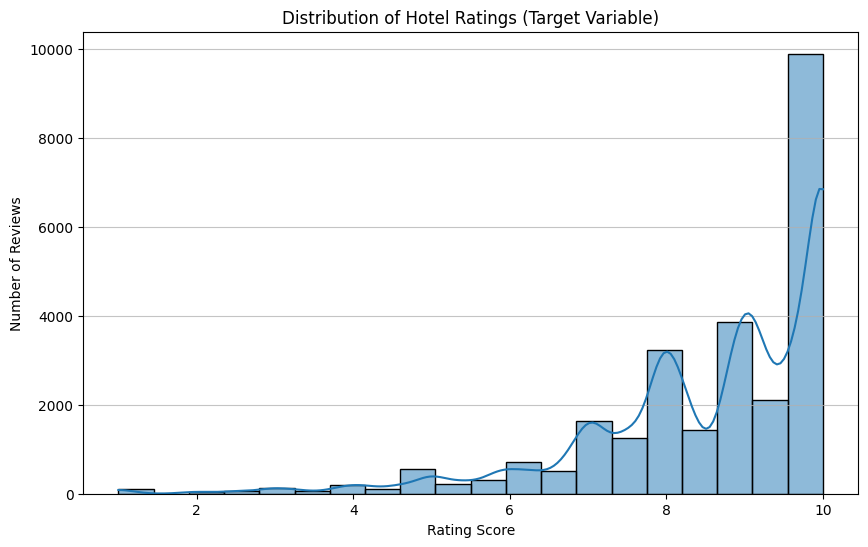


Descriptive Statistics for 'rating':
count    26386.000000
mean         8.560669
std          1.566554
min          1.000000
25%          7.900000
50%          9.000000
75%         10.000000
max         10.000000
Name: rating, dtype: float64

Unique values in 'rating':
[10.   9.   9.2  8.3  7.5  8.   9.6  8.8  7.9  7.   7.1  6.   6.7  5.
  9.5  2.   3.   3.8  4.2  5.8  5.4  1.   4.6  6.3  8.5  3.3  2.9  4.
  2.5  4.5  5.5  8.1  3.5  9.4  6.5  6.9]

Value counts for 'rating':
rating
1.0       95
2.0       44
2.5       55
2.9       40
3.0       78
3.3       67
3.5        1
3.8       81
4.0      104
4.2      101
4.5        6
4.6      162
5.0      384
5.4      228
5.5       12
5.8      294
6.0      305
6.3      400
6.5       10
6.7      512
6.9        1
7.0      907
7.1      735
7.5     1242
7.9     1141
8.0     2086
8.1        1
8.3     1393
8.5       33
8.8     1538
9.0     2319
9.2     2050
9.4        8
9.5       57
9.6     2463
10.0    7433
Name: count, dtype: int64


In [156]:
#Creating an histogram for the target variable 'rating'
rating_column_name = 'rating'

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned[rating_column_name], bins=20, kde=True) # Adjust bins if rating scale is very small/large
plt.title(f'Distribution of Hotel Ratings (Target Variable)')
plt.xlabel('Rating Score')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Get descriptive statistics for the varible 'rating'
print(f"\nDescriptive Statistics for '{rating_column_name}':")
print(df_cleaned[rating_column_name].describe())

# Check for specific unique values (e.g., 1-10)
if df_cleaned[rating_column_name].dtype in ['int64', 'float64']:
    print(f"\nUnique values in '{rating_column_name}':")
    print(df_cleaned[rating_column_name].unique())
    print(f"\nValue counts for '{rating_column_name}':")
    print(df_cleaned[rating_column_name].value_counts().sort_index())

Based on the histogram, the key findings are that the 'rating' column is a numerical target with ample data (26386 non-null entries). However, it exhibits a strong positive skew, with a mean of 8.56, and over 75% of ratings are 7.9 or higher, making lower ratings significantly sparse.

This skew will cause regression models to be biased towards predicting higher ratings, potentially performing poorly on and underrepresenting the crucial, but rare, lower (negative) ratings.

Moving forward with the regression to predict the rating will mean that:

*   I will need to prioritize MAE/RMSE for evaluation and analyze errors across rating ranges.
*  Employ robust regression models like Gradient Boosting Machines (XGBoost, LightGBM).
*   Focus feature engineering on attributes indicative of negative sentiment to aid prediction of sparse low ratings.
*   Consider converting to a classification problem by binning ratings if direct regression proves too challenging.

#### Sentiment Classification (Classification Problem derived from rating)

add a reasoning for the 9/0 threshold and not the 8.0

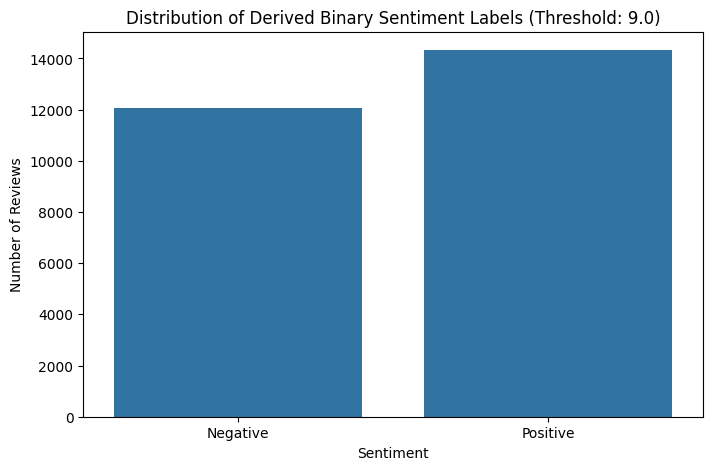


Derived Binary Sentiment Label Counts:
sentiment_label
Positive    14330
Negative    12056
Name: count, dtype: int64

Derived Binary Sentiment Label Proportions:
sentiment_label
Positive    54.31
Negative    45.69
Name: proportion, dtype: float64


In [157]:
# Define a function to categorize ratings into sentiments
def derive_binary_sentiment(rating):
    if rating >= 9.0:
        return 'Positive'
    else:
        return 'Negative'

# Create the new binary sentiment column
df_cleaned['sentiment_label'] = df_cleaned[rating_column_name].apply(derive_binary_sentiment)

#df_classification['sentiment_label'] = df_classification['rating'].apply(derive_binary_sentiment)

# Display the distribution of sentiment labels
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_label', data=df_cleaned, order=['Negative', 'Positive'])
plt.title('Distribution of Derived Binary Sentiment Labels (Threshold: 9.0)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

# Print counts and percentages to quantify imbalance
sentiment_counts = df_cleaned['sentiment_label'].value_counts()
print("\nDerived Binary Sentiment Label Counts:")
print(sentiment_counts)
print("\nDerived Binary Sentiment Label Proportions:")
print((df_cleaned['sentiment_label'].value_counts(normalize=True) * 100).round(2))


Your rating data was effectively transformed into a well-balanced binary classification target (Positive: 53.72%, Negative: 46.28%) using the rating 9.0 as a threshold. This near-even split mitigates class imbalance issues, aiding robust classifier training and evaluation.

The limitations of this split is that, the 9.0 threshold is arbitrary, leading to a loss of original rating granularity where diverse dissatisfaction levels are grouped. Reviews just below 9.0 are categorized with truly negative ones, potentially misrepresenting nuanced sentiment. "Neutral" reviews might also fall into "Negative" based purely on score.

To address the limitations, I will be performing a boundary analysis during model evaluation to understand misclassifications near the 9.0 mark as well a conducting detailed error analysis on miscategorized reviews.

## Data Processing

### Handling missing values

In [158]:
# Current missing values
df_cleaned.isnull().sum()

,0
review_title,1
reviewed_at,0
reviewed_by,0
hotel_name,0
avg_rating,0
nationality,16
rating,0
raw_review_text,184
tags,184
sentiment_label,0


We will manage the the missing values for 'review_title', 'nationality', 'raw_review_text' and 'tags' in the following way:

1.  review_title: I will add a placeholder "No Title" to preserve data. This approach is ideal because only one value is missing, and mean/median/mode imputation isn't suitable for text.
2.  nationality: I will fill in the NaNs with the mode so the most frequent nationality. Using the mode is a common and  reasonable approach for categorical features as it preserves the distribution of the existing data as much as possible by assuming the missing values are most likely to belong to the most common category. While it might introduce a slight bias towards the mode, for a small number of missing values (16 in this case), the impact will be minimal.

3.  raw_review_text: I will add a placeholder in this case an empty string. In this case an empty String '' is the best option as in an NLP pipeline this will naturally result in no tokens or zero vectors, which is the correct representation for an absent review.

4.  tags: I will add a placeholder in this case an empty string.


In [159]:
# Review title
df_cleaned['review_title'].fillna('No Title', inplace=True)

# Nationality
most_frequent_nationality = df_cleaned['nationality'].mode()[0]
df_cleaned['nationality'].fillna(most_frequent_nationality, inplace=True)

# Raw_review_text
df_cleaned['raw_review_text'].fillna('', inplace=True)

# Tags
df_cleaned['tags'].fillna('', inplace=True)

In [160]:
# Validating that the missing values were handled
df_cleaned.isnull().sum()

,0
review_title,0
reviewed_at,0
reviewed_by,0
hotel_name,0
avg_rating,0
nationality,0
rating,0
raw_review_text,0
tags,0
sentiment_label,0


### Feature Engineering from Structured Data

The goal of this part is to extract more information from existing numerical and categorical features, especially time-related ones, to potentially improve model performance or provide deeper insights.

#### Step 1: Convert reviewed_at to Datetime object

Convert reviewed_at in df_cleaned to a pandas datetime object as this allows easy extraction of year, month, day, day of week and facilitates date arithmetic.

In [161]:
# Convert to datetime
df_cleaned['reviewed_at'] = pd.to_datetime(df_cleaned['reviewed_at'])


In [162]:
# Now that reviewed_at is a datetime object, I can easily extract various time-based features.
# Seasonality: Month, quarter, and day of week can capture seasonal trends in reviews.
# Temporal Trends: Year can capture long-term trends or changes.
# Recency: review_age_days

# Basic features to create
df_cleaned['review_year'] = df_cleaned['reviewed_at'].dt.year
df_cleaned['review_month'] = df_cleaned['reviewed_at'].dt.month
df_cleaned['review_day'] = df_cleaned['reviewed_at'].dt.day
df_cleaned['review_day_of_week'] = df_cleaned['reviewed_at'].dt.dayofweek # Monday=0, Sunday=6
df_cleaned['review_quarter'] = df_cleaned['reviewed_at'].dt.quarter

# Age relative to the latest review date in the dataset
latest_review_date = df_cleaned['reviewed_at'].max()
df_cleaned['review_age_days'] = (latest_review_date - df_cleaned['reviewed_at']).dt.days

print("\nDataFrame after adding time-based features:")
print(df_cleaned[['reviewed_at', 'review_year', 'review_month', 'review_day', 'review_day_of_week', 'review_quarter', 'review_age_days']].head())


DataFrame after adding time-based features:
  reviewed_at  review_year  review_month  review_day  review_day_of_week  \
0  2021-07-11         2021             7          11                   6   
1  2019-11-24         2019            11          24                   6   
2  2020-01-03         2020             1           3                   4   
3  2019-09-08         2019             9           8                   6   
4  2019-06-23         2019             6          23                   6   

   review_quarter  review_age_days  
0               3                8  
1               4              603  
2               1              563  
3               3              680  
4               2              757  


#### Step 2: Aggregation Features

Reviewer centric metrics?

In [163]:
#reviewer_stats = df_cleaned.groupby('reviewed_by').agg(reviewer_total_reviews=('reviewed_by', 'count'),reviewer_avg_rating=('rating', 'mean')).reset_index()
#df_cleaned = pd.merge(df_cleaned, reviewer_stats, on='reviewed_by', how='left')

#print("\nDataFrame after adding aggregation features:")
#print(df_cleaned[['hotel_name', 'rating', 'hotel_avg_rating', 'hotel_total_reviews',
#          'reviewed_by', 'reviewer_total_reviews', 'reviewer_avg_rating']].head())

### Feature Selection

In [164]:
# Define target variable
y = df_cleaned['rating']

X = df_cleaned.drop(columns=[
    'rating', 'reviewed_at', 'review_title', 'raw_review_text', 'tags',
    'nationality', 'reviewed_by', 'hotel_name', 'sentiment_label'

])



Correlation of numerical features with 'rating':
 avg_rating            0.470730
review_age_days       0.048466
review_month          0.012990
review_quarter        0.007443
review_day           -0.008063
review_day_of_week   -0.009854
review_year          -0.047088
dtype: float64


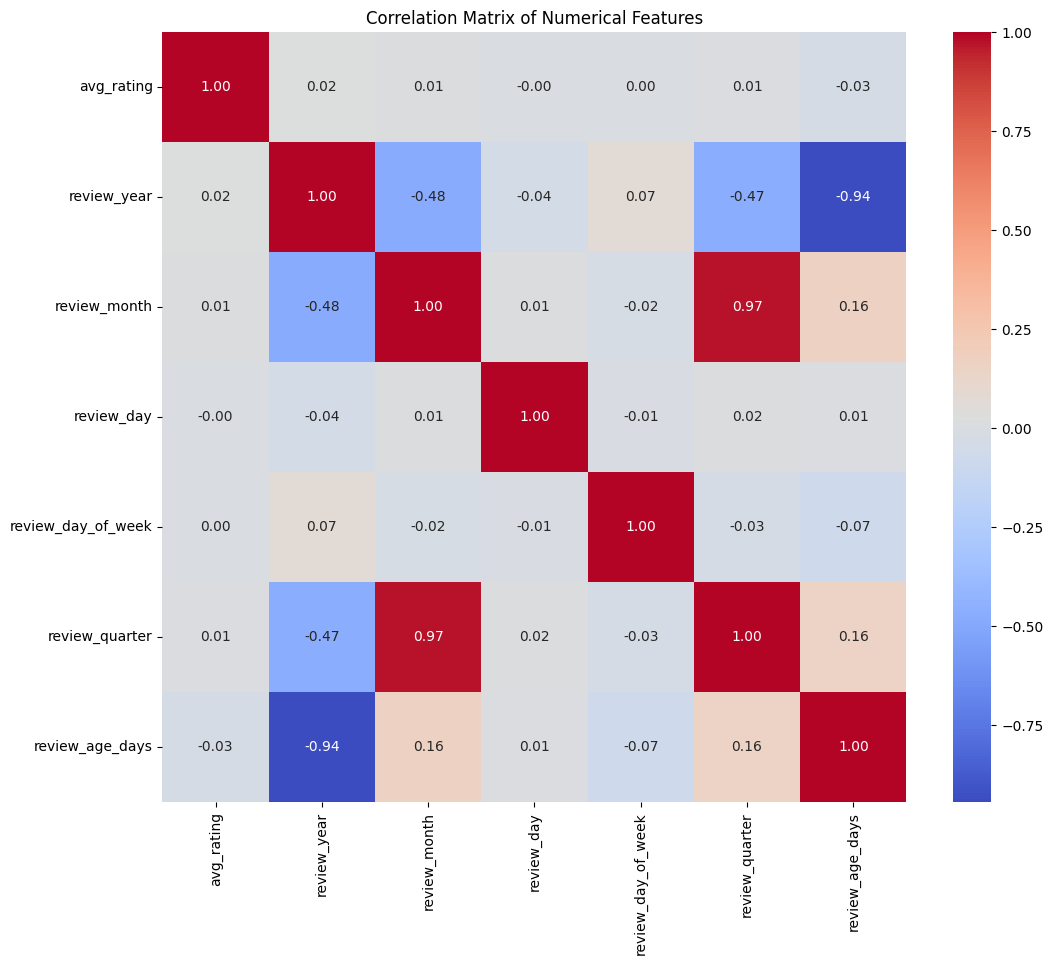

In [165]:
# Select only numerical columns for correlation calculation
numerical_cols = X.select_dtypes(include=np.number).columns

# Calculate correlation with the target variable
correlations = X[numerical_cols].corrwith(y).sort_values(ascending=False)
print("\nCorrelation of numerical features with 'rating':\n", correlations)

# Visualize correlation matrix among numerical features if you have many
plt.figure(figsize=(12, 10))
sns.heatmap(X[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


Based on the correlation matrix, we will be dropping the following variables: review_quarter, review_day and review_year. These show extremely low correlation with rating and review_quarter is redundant with review_month. review_year is also redundant with review_age_days. Removing them reduces noise and multicollinearity.

I'm keeping review_age_days because even if correlation is low, temporal features can have non-linear impacts or interactions not captured by simple correlation, warranting further evaluation by other methods.

In [166]:
# Columns to drop based on low correlation and redundancy
columns_to_drop_now = [
    'review_quarter',
    'review_day',
    'review_year'
]

# Ensure these columns actually exist in X before dropping
existing_columns_to_drop = [col for col in columns_to_drop_now if col in X.columns]

if existing_columns_to_drop:
    X_filtered = X.drop(columns=existing_columns_to_drop)
    print(f"\nDropped columns: {existing_columns_to_drop}")
    print("\nFeatures (X_filtered) columns after preliminary drops:\n", X_filtered.columns.tolist())
    print("\nShape of X_filtered:", X_filtered.shape)
else:
    X_filtered = X.copy()
    print("\nNo additional columns to drop based on this correlation analysis.")


Dropped columns: ['review_quarter', 'review_day', 'review_year']

Features (X_filtered) columns after preliminary drops:
 ['avg_rating', 'review_month', 'review_day_of_week', 'review_age_days']

Shape of X_filtered: (26386, 4)


In [167]:
# F-regression
print("\n--- Feature Selection using F-regression (SelectKBest) on X_filtered ---")
selector_f_reg_filtered = SelectKBest(score_func=f_regression, k='all')
selector_f_reg_filtered.fit(X_filtered, y)
f_scores_filtered = pd.DataFrame({'Feature': X_filtered.columns, 'F-Score': selector_f_reg_filtered.scores_, 'P-value': selector_f_reg_filtered.pvalues_})
f_scores_filtered = f_scores_filtered.sort_values(by='F-Score', ascending=False)
print(f_scores_filtered)

# Mutual Information Regression
print("\n--- Feature Selection using Mutual Information Regression (SelectKBest) on X_filtered ---")
selector_mi_filtered = SelectKBest(score_func=mutual_info_regression, k='all')
selector_mi_filtered.fit(X_filtered, y)
mi_scores_filtered = pd.DataFrame({'Feature': X_filtered.columns, 'Mutual_Info_Score': selector_mi_filtered.scores_})
mi_scores_filtered = mi_scores_filtered.sort_values(by='Mutual_Info_Score', ascending=False)
print(mi_scores_filtered)


--- Feature Selection using F-regression (SelectKBest) on X_filtered ---
              Feature      F-Score       P-value
0          avg_rating  7510.571920  0.000000e+00
3     review_age_days    62.121234  3.353500e-15
1        review_month     4.452992  3.484954e-02
2  review_day_of_week     2.561953  1.094753e-01

--- Feature Selection using Mutual Information Regression (SelectKBest) on X_filtered ---
              Feature  Mutual_Info_Score
3     review_age_days           0.321983
0          avg_rating           0.159258
1        review_month           0.020891
2  review_day_of_week           0.001156


Based on the F-regression and Mutual Information scores we will drop and keep the following variables:

Drop:

1. review_day_of_week: Its F-score is low, and the P-value (0.109) is above the 0.05 significance threshold. The Mutual Information score is also extremely low (0.006). This indicates it has little to no linear or non-linear relationship with rating.

Keep (for further evaluation by model-based methods):

1. review_age_days: Exhibits high statistical significance (low P-value) and is the strongest feature by Mutual Information, suggesting a potentially strong non-linear relationship.

2. review_month: While its Mutual Information score is low, its F-score's P-value (0.0348) is still below 0.05. It might have a subtle linear impact or interact with other features, so it's worth assessing with tree-based models next.

As only 'review_month' and 'review_age_days' are left, I'm going to evaluate if it will be ok keeping both or not using a Variance Inflation Factor (VIF) calculation:

In [168]:
# Adding a constant as this is a good practice for VIF calculation
X_vif = X_filtered[['review_month', 'review_age_days']].copy() # Just these two for now
X_vif['intercept'] = 1

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\nVariance Inflation Factor (VIF) for review_month and review_age_days:")
print(vif_data)


Variance Inflation Factor (VIF) for review_month and review_age_days:
           feature       VIF
0     review_month  1.027271
1  review_age_days  1.027271
2        intercept  9.789823


The Variance Inflation Factor (VIF) for both review_month and review_age_days is approximately 1.03. This score, being very close to 1, indicates extremely low multicollinearity between these two features.

Crucially, these variables capture distinct temporal aspects. Review_month accounts for seasonality, reflecting potential cyclical patterns in hotel ratings throughout the year (e.g., holiday seasons, peak travel months). In contrast, review_age_days measures recency, indicating how old a review is, which can reflect current hotel conditions or reviewer sentiment trends over time.

Since they provide independent information about different facets of time and do not exhibit problematic redundancy, retaining both enriches the model's understanding of review dynamics. This allows the model to leverage both seasonal influences and the impact of review recency, leading to a more comprehensive and potentially more accurate predictive capability without introducing noise or instability.

In [169]:
# Final cleaned df with feature engineering variables define through feature selection
df_filtered = df_cleaned.drop(columns=[ 'review_quarter', 'review_day', 'review_year',  'review_day_of_week'])

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26386 entries, 0 to 26674
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   review_title     26386 non-null  object        
 1   reviewed_at      26386 non-null  datetime64[ns]
 2   reviewed_by      26386 non-null  object        
 3   hotel_name       26386 non-null  object        
 4   avg_rating       26386 non-null  float64       
 5   nationality      26386 non-null  object        
 6   rating           26386 non-null  float64       
 7   raw_review_text  26386 non-null  object        
 8   tags             26386 non-null  object        
 9   sentiment_label  26386 non-null  object        
 10  review_month     26386 non-null  int32         
 11  review_age_days  26386 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(7)
memory usage: 2.5+ MB


### Text Preprocessing

This text preprocessing methodology is meticulously designed to transform raw, unstructured review data into a clean, normalized, and semantically rich format suitable for advanced natural language processing tasks.

This multi-stage process begins with fundamental cleanups, including lowercasing to standardize text representation and the removal of URLs and HTML tags to eliminate extraneous noise. Subsequently, emojis and emoticons are converted into descriptive text to capture their inherent sentiment, while the text is simultaneously tokenized into individual words. I then apply lemmatization to reduce words to their base forms, ensuring consistent representation across variations, and systematically remove punctuation and numbers to focus on meaningful lexical content. A crucial step involves comprehensive stop word removal, which not only leverages standard lists but also incorporates custom, domain-specific terms (e.g., "hotel," "room") that lack discriminative power in review contexts.

Furthermore, I implement sophisticated negation handling by tagging words that follow negations (e.g., "good_NEG" from "not good"), thus preserving accurate sentiment. Finally, optional spell correction is employed to address typographical errors, preventing data sparsity and ensuring that misspelled words contribute correctly to feature representation. This rigorous preprocessing pipeline is essential for generating high-quality features for subsequent TF-IDF modeling and enhancing the overall performance of our machine learning models.


In [170]:
# Initialize spaCy
# Load a pre-trained English model. 'en_core_web_sm' is a good starting point.
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy 'en_core_web_sm' model loaded successfully.")
except OSError:
    print("spaCy 'en_core_web_sm' model not found. Please run: !python -m spacy download en_core_web_sm")
    import sys
    sys.exit("SpaCy model not found. Please download it first.")

spaCy 'en_core_web_sm' model loaded successfully.


In [171]:
# 1. Clone my github to bring my helper function: processing_text.py file into my Colab environment.
repo_url = "https://github.com/KBE25/hotel_sentiment.git"
repo_name = "hotel_sentiment"

# Check if the repo is already cloned to avoid re-cloning on successive runs
if not os.path.exists(repo_name):
    print(f"Cloning {repo_name} from GitHub...")
    !git clone {repo_url}
    print(f"Repository '{repo_name}' cloned successfully.")
else:
    print(f"Repository '{repo_name}' already exists. Skipping clone.")

# Navigate into the cloned repository's directory
# This is important so Python can find the helper file directly
%cd {repo_name}/
print(f"Current working directory changed to: {os.getcwd()}")

Repository 'hotel_sentiment' already exists. Skipping clone.
/content/hotel_sentiment
Current working directory changed to: /content/hotel_sentiment


In [172]:
# The current working directory should now be the root of your cloned repo
# 'processing_text.py' is directly in the root of my repository.
path_to_add = os.getcwd()

if path_to_add not in sys.path:
    sys.path.append(path_to_add)
    print(f"Added '{path_to_add}' to sys.path for module import.")

In [173]:
# 2. Import the functions from my processing_text.py helper file
try:
    from processing_text import (preprocess_text_enhanced_spacy, parallelize_series_with_tqdm, worker_initializer)
    print("Successfully imported preprocessing functions from 'processing_text.py'.")
except ImportError as e:
    print(f"Error importing functions from processing_text.py: {e}")
    print("Please check: 1. File name 'processing_text.py'. 2. Its location in your repo. 3. Python path.")
    # Exit the script if the helper cannot be loaded
    sys.exit("Failed to import preprocessing helper. Exiting.")

Successfully imported preprocessing functions from 'processing_text.py'.


In [174]:
# These lines are currently commented out because the core text preprocessing took a really long time
# In this case, we ran the preprocessing and then saved the filtered dataframe with the preprocessed text information
# To run the model below, you will need to uncomment all the below line
# This step takes a really long time so after running it the next step will be to save it so is easier just to load the data and run the rest of the analysis

# 3. Run the core text preprocessing

#if __name__ == '__main__':
#    text_cols_to_process = ['raw_review_text', 'review_title', 'tags']
#    processed_output_cols = [f'{col}_processed' for col in text_cols_to_process]
#
#    for col in text_cols_to_process:
#        print(f"Starting parallel processing for column: '{col}' (with full spaCy pipeline)...")
#        df_filtered[f'{col}_processed'] = parallelize_series_with_tqdm(
#            df_filtered[col],
#            preprocess_text_enhanced_spacy,
#            n_cores=None, # Use all available CPU cores
#           apply_spell_correction=True # Pass keyword arguments
#         )
#
#print(f"Finished processing column: '{col}'")
#print("\n--- Processed Text Columns Sample (after all preprocessing) ---")
#print(df_filtered[processed_output_cols].head(2).to_string())
#print("-" * 50)

In [175]:
# These code lines are currently commented out as we have already saved the dataframe
# This step saves the df_filtered (including original and new processed columns) to a file for later use, avoiding reprocessing.

# 4. Saving the processed dataframe

# Create the local directory if it doesn't exist
# This block should ideally be run once before any saving operation to this directory
#local_save_dir = '/content/downloaded_models'
#os.makedirs(local_save_dir, exist_ok=True)

# Define the full path for your saved dataframe file within the specified directory
#output_filename = os.path.join(local_save_dir, 'df_filtered_processed_3.parquet')
#df_filtered.to_parquet(output_filename, index=False)

#print(f"Processed dataframe saved to: {output_filename}")

To be able to load the data saved in step (4) we are going to have to complete a couple of additional steps using Kaggle. After I completed step (4) and saved the df_filtered data I went ahead and downloaded the data and uploaded into Kaggle for easier management. To be able to recover this information the next steps are needed:

1. Create an API connection with Kaggle (which was done when we load the dataset)
2. Download the processed data from Kaggle
3. Load the data


1. Creating n API connection with Kaggle was completed at the beginning of data acquisition

 #### 2. Downloading the dataset from Kaggle to Colab

In [176]:
# 1. Changing working directort back to /content/
%cd /content/

# 2. Verifying that I'm now in  /content/
!pwd
# This will show the contents of /content/, including the cloned repo folder
!ls


/content
/content
booking-com-hotel-reviews.zip	 random-search-3.zip
booking_reviews.csv		 random_search_lgbm_1.joblib
deep_learning_model.keras	 random-search-lgbm-1.zip
deep-learning-model.zip		 random_search_rf_1.joblib
df-filtered3.zip		 random-search-rf-1.zip
df_filtered_processed_3.parquet  random_search_svm_2.joblib
hotel_sentiment			 random-search-svm-2.zip
non_text_preprocessor.joblib	 sample_data
non-text-preprocessor.zip	 tokenizer.pkl
random_search_3.joblib		 tokenizer.zip


In [177]:
! kaggle datasets download -d karinabe25us/df-filtered3
! unzip df-filtered3.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/df-filtered3
License(s): apache-2.0
df-filtered3.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  df-filtered3.zip
replace df_filtered_processed_3.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: df_filtered_processed_3.parquet  


 #### 3. Loading the dataset using pandas

In [178]:
#Loading the model

# Define the full path to the processed Parquet file
file_path = '/content/df_filtered_processed_3.parquet'

# Load the DataFrame directly from the Parquet file
df_filtered = pd.read_parquet(file_path)

#Confirming the dataset has the correct information
print(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26386 entries, 0 to 26385
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   review_title               26386 non-null  object        
 1   reviewed_at                26386 non-null  datetime64[ns]
 2   reviewed_by                26386 non-null  object        
 3   hotel_name                 26386 non-null  object        
 4   avg_rating                 26386 non-null  float64       
 5   nationality                26386 non-null  object        
 6   rating                     26386 non-null  float64       
 7   raw_review_text            26386 non-null  object        
 8   tags                       26386 non-null  object        
 9   sentiment_label            26386 non-null  object        
 10  review_month               26386 non-null  int32         
 11  review_age_days            26386 non-null  int64         
 12  raw_

Now that we have loaded the processed data we can move it the next step, running TF-IDF.

When i downloaded the github, I changed the directory to content/hotel_sentiment. The next code will be added to reset my path for future downloads to /content.

### TF-IDF Modelling

Why TF-IDF?


The method that I will be using for TF-IDF is by concatenning all processed text columns.

In [179]:
# 1. Create a combined text column with the text processed data

# Create a new 'combined_text' column by joining the processed text from all relevant columns
processed_cols = ['raw_review_text_processed', 'review_title_processed', 'tags_processed']

#  Processed_cols will be ['raw_review_text_processed', 'review_title_processed', 'tags_processed']
df_filtered['combined_text'] = df_filtered[processed_cols].fillna('').agg(' '.join, axis=1)

# Display a sample of the combined text to verify
print("\nSample of 'combined_text' column:")
for i, text in enumerate(df_filtered['combined_text'].head(3)):
    print(f"Review {i+1}: {text[:100]}...")
print("-" * 50)


Sample of 'combined_text' column:
Review 1: perfect copy relax exceptional junior suite stay submit...
Review 2: friendly host perfect breakfast highly recommend b&b enjoy lot deluxe suite stay submit...
Review 3: want beach winter location fab apartment quiet equip spotless clean exceptional apartment sea view s...
--------------------------------------------------


In [180]:
# 2. Extract the combined documents into a list
documents_for_tfidf = df_filtered['combined_text'].tolist()

# 3. Initialize TfidfVectorizer
#    - max_features: Limits the vocabulary size to the top 5000 most frequent terms/n-grams
#    - ngram_range=(1, 2): Considers both single words (unigrams) and two-word phrases (bigrams) as features
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1, 2))


# 4. Fit and Transform the documents
#    - fit: learns the vocabulary and IDF values from your combined_text documents
#    - transform: converts the documents into the TF-IDF numerical matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(documents_for_tfidf)

print(f"\nTF-IDF Matrix Shape (rows: reviews, columns: features): {tfidf_matrix.shape}")
print(f"Sample TF-IDF features (first 10 out of {tfidf_vectorizer.get_feature_names_out().shape[0]}):")
print(tfidf_vectorizer.get_feature_names_out()[:10])
print("\nAnd some last 10 features:")
print(tfidf_vectorizer.get_feature_names_out()[-10:])
print("-" * 50)



TF-IDF Matrix Shape (rows: reviews, columns: features): (26386, 5000)
Sample TF-IDF features (first 10 out of 5000):
['30am' '30pm' '_neg' '_neg star_neg' 'able' 'able park' 'able_neg'
 'absolute' 'absolutely' 'absolutely amazing']

And some last 10 features:
['yoghurt' 'yogurt' 'yore' 'young' 'young child' 'youth' 'ypres' 'yummy'
 'zircon' 'zone']
--------------------------------------------------


Below we will be evaluating the above TF-IDF for sentiment analysis

In [181]:
# Step 1: Inspect Global TF-IDF Features (Vocabulary and IDF Scores)
# This helps understand what words/phrases the vectorizer considers most "important"
# High IDF values usually mean a term is more discriminative.

print("\n### 1. Global TF-IDF Feature Inspection (Vocabulary & IDF Scores) ###")

feature_names = tfidf_vectorizer.get_feature_names_out()
idf_scores = tfidf_vectorizer.idf_

# Create a DataFrame for easier sorting and inspection of features
feature_idf_df = pd.DataFrame({'feature': feature_names, 'idf_score': idf_scores})

# Sort by IDF score in descending order to see the most discriminative terms
feature_idf_df_sorted_desc = feature_idf_df.sort_values(by='idf_score', ascending=False).reset_index(drop=True)

print("\nTop 20 global features by IDF score (most discriminative terms):")
print(feature_idf_df_sorted_desc.head(20).to_string())
print("\nInterpretation: These terms appear relatively rarely but are impactful when they do, \nImportant to look for strong sentiment words, specific complaints/praises, or critical aspects of a hotel.")
print("-" * 50)

# Sort by IDF score in ascending order to see the least discriminative terms
feature_idf_df_sorted_asc = feature_idf_df.sort_values(by='idf_score', ascending=True).reset_index(drop=True)

print("\nBottom 20 global features by IDF score (least discriminative, very common terms):")
print(feature_idf_df_sorted_asc.head(20).to_string())
print("\nInterpretation: These terms appear in many documents. These are words survived preprocessing but hold little sentiment weight. \nIf there are highly emotional or specific terms here, min_df/max_df or stop words might need adjustment.")
print("-" * 50)


### 1. Global TF-IDF Feature Inspection (Vocabulary & IDF Scores) ###

Top 20 global features by IDF score (most discriminative terms):
                  feature  idf_score
0   downthumbs downthumbs  10.487480
1              downthumbs  10.487480
2                  bedbug   9.101185
3                   quilt   8.983402
4             holiday inn   8.878042
5             thumb thumb   8.878042
6                  cinema   8.878042
7                  steven   8.878042
8                  sensor   8.782731
9                restroom   8.782731
10                    mon   8.782731
11                  lodge   8.782731
12               art deco   8.695720
13                 father   8.695720
14               baby cot   8.695720
15                extreme   8.695720
16               high end   8.695720
17                  haven   8.695720
18         host fantastic   8.615677
19             super easy   8.615677

Interpretation: These terms appear relatively rarely but are impactful when they do, 

In [182]:
# Step 2: Inspect Top TF-IDF Terms for Specific Documents
# This helps confirm if the vectorizer captures the essence of individual reviews and their sentiment.
# Pay attention to strong positive/negative words and aspects mentioned.

print("\n### 2. Per-Document TF-IDF Feature Inspection (Top Terms per Review) ###")

# Function to get top N TF-IDF terms for a given document index
def get_top_tfidf_terms_for_doc(doc_index, tfidf_matrix, tfidf_vectorizer, n=15):
    if not 0 <= doc_index < tfidf_matrix.shape[0]:
        return "Invalid document index."

    feature_array = np.array(tfidf_vectorizer.get_feature_names_out())
    tfidf_row = tfidf_matrix[doc_index].toarray().flatten()

    # Get indices of the top N scores in descending order
    top_n_indices = tfidf_row.argsort()[-n:][::-1]
    top_n_scores = tfidf_row[top_n_indices]
    top_n_features = feature_array[top_n_indices]

    return list(zip(top_n_features, top_n_scores))

# Select some review indices to inspect
review_indices_to_inspect = [300, 50, 10000, 20000]

for idx in review_indices_to_inspect:
    # Ensure the index exists in your DataFrame
    if idx < len(df_filtered):
        print(f"\n--- Review Index: {df_filtered.index[idx]} ---")
        print(f"Original Text: {df_filtered.loc[df_filtered.index[idx], 'raw_review_text']}")
        print(f"Combined Processed Text: {df_filtered.loc[df_filtered.index[idx], 'combined_text']}")

        top_terms = get_top_tfidf_terms_for_doc(idx, tfidf_matrix, tfidf_vectorizer, n=15)
        print("Top 15 TF-IDF Terms and Scores for this review:")
        for term, score in top_terms:
            print(f"  - {term}: {score:.4f}")
    else:
        print(f"\nWarning: Review index {idx} out of bounds for df_filtered.")
    print("-" * 60)



### 2. Per-Document TF-IDF Feature Inspection (Top Terms per Review) ###

--- Review Index: 300 ---
Original Text: <p class="review_pos "><svg aria-label="Positive point" class="bk-icon -fonticon-plus review_item_icon" fill="#008009" height="14" role="img" width="14" viewbox="0 0 32 32" aria-hidden="true" focusable="false">
  <path d="M32 16c0 8.836-7.162 16-16 16-8.834 0-16-5.74-16-16C0 6.451 7.166 0 16 0c8.838 0 16 7.162 16 16zm-6.4-2.585c0-.369-.031-.616-.4-.616h-5.998V7.018c0-.369-.297-.62-.666-.62h-5.068c-.369 0-.666.251-.666.62v5.781H6.901c-.369 0-.499.247-.499.616v5.118c0 .369.132.666.499.666H12.8v5.833c0 .369.297.565.666.565h5.068c.369 0 .666-.196.666-.565v-5.833h5.998c.369 0 .4-.297.4-.666v-5.118z"></path>
</svg><span itemprop="reviewBody">I usually don't like to spend time rating hotels. However, this place left me with such a great memory that I feel it is necessary to share my view with others.This one bed house is so beautifully decorated and the bed is extremely comforta

In [183]:
# Ensure current_feature_names is obtained fresh, right before this check.
# This variable comes from the tfidf_vectorizer fitted in your main notebook cells.
current_feature_names = tfidf_vectorizer.get_feature_names_out()

# Search for the lowercase '_neg' suffix, as seen in your LR coefficients (e.g., 'available_neg good')
found_negated_features = [f for f in current_feature_names if '_neg' in f]

if found_negated_features:
    print(f"\n Found {len(found_negated_features)} negated features in the vocabulary.")
    print("Sample of found negated features (first 20):")
    for f in found_negated_features[:min(20, len(found_negated_features))]:
        print(f"  - {f}")

    # Checking for specific expected negated terms (using lowercase _neg for consistency)
    expected_negations_to_check = ['good_neg', 'bad_neg', 'clean_neg', 'comfortable_neg', 'not_good_neg', 'available_neg good']
    print("\nChecking for specific expected negated terms:")
    for neg_term in expected_negations_to_check:
        if neg_term in current_feature_names:
            print(f"  - '{neg_term}' found.")
        else:
            print(f"  - '{neg_term}' NOT found. (This might be due to low frequency/min_df or specific context).")
else:
    print("\nATTENTION: Still no negated features found in the vocabulary by this diagnostic.")
    print("This is highly unusual given the previous strong evidence from Logistic Regression and Chi-Squared results.")
    print("This suggests the problem is specifically with *this diagnostic block* and NOT your actual preprocessing or TF-IDF effectiveness.")
    print("\nDebugging Info - First 100 features in current vocabulary:")
    print(current_feature_names[:100])
    print("\nDebugging Info - Checking for 'available_neg good' (known from LR) directly:")
    if 'available_neg good' in current_feature_names:
        print("  - 'available_neg good' IS PRESENT in the vocabulary.")
        print("  - The diagnostic logic is flawed if it still reports no negated features.")
    else:
        print("  - 'available_neg good' is NOT present in the vocabulary. This would contradict LR/Chi2 results and suggest TF-IDF filtering is too aggressive for these terms.")
    print("\nConsider checking if TF-IDF was re-fitted without updating `tfidf_vectorizer` variable globally.")

print("-" * 50)


 Found 213 negated features in the vocabulary.
Sample of found negated features (first 20):
  - _neg
  - _neg star_neg
  - able_neg
  - ac_neg
  - acceptable_neg
  - access_neg
  - affect_neg
  - air_neg
  - air_neg con_neg
  - air_neg condition_neg
  - air_neg conditioner_neg
  - air_neg conditioning_neg
  - airco_neg
  - aircon_neg
  - allow_neg
  - applicable_neg
  - ask_neg
  - available_neg
  - available_neg disappointing
  - available_neg excellent

Checking for specific expected negated terms:
  - 'good_neg' found.
  - 'bad_neg' found.
  - 'clean_neg' found.
  - 'comfortable_neg' found.
  - 'not_good_neg' NOT found. (This might be due to low frequency/min_df or specific context).
  - 'available_neg good' found.
--------------------------------------------------


In [184]:
# Step 4: Dimensionality and Sparsity Check
# Understand the basic structure of the TF-IDF matrix.

print("\n### 4. Dimensionality and Sparsity Check ###")
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Number of non-zero elements (NNZ): {tfidf_matrix.nnz}")
total_elements = tfidf_matrix.shape[0] * tfidf_matrix.shape[1]
sparsity = 100 * (1 - (tfidf_matrix.nnz / total_elements))
print(f"Sparsity of TF-IDF Matrix: {sparsity:.2f}%")
print("\nInterpretation: High sparsity (e.g., >98%) is typical for TF-IDF and indicates that most documents do not contain most words in the vocabulary. \nThis confirms it's a sparse matrix and might benefit from dimensionality reduction for some models or memory efficiency.")
print("-" * 50)



### 4. Dimensionality and Sparsity Check ###
TF-IDF Matrix Shape: (26386, 5000)
Number of non-zero elements (NNZ): 632612
Sparsity of TF-IDF Matrix: 99.52%

Interpretation: High sparsity (e.g., >98%) is typical for TF-IDF and indicates that most documents do not contain most words in the vocabulary. 
This confirms it's a sparse matrix and might benefit from dimensionality reduction for some models or memory efficiency.
--------------------------------------------------


In [185]:
# Step 5: Pre-Modeling data preprocessing

# Currently sentiment_label is set as positive/negative in df_filtered so we will map it to 1/0
# Convert 'Positive'/'Negative' sentiment labels to numerical (1/0)
df_filtered['sentiment_numeric'] = df_filtered['sentiment_label'].map({'Positive': 1, 'Negative': 0})

# Step 6: Perform Train-Test Split
# For the split, X should be the tfidf_matrix and y should be the numeric sentiment.
# No need to drop other columns from df_filtered here, as we are working directly with tfidf_matrix.
X_features = tfidf_matrix
y_target = df_filtered['sentiment_numeric']

# Split the data, ensuring stratification (balanced sentiment classes in train/test)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nTraining sentiment distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing sentiment distribution:\n{y_test.value_counts(normalize=True)}")
print("-" * 50)

X_train shape: (21108, 5000)
X_test shape: (5278, 5000)
y_train shape: (21108,)
y_test shape: (5278,)

Training sentiment distribution:
sentiment_numeric
1    0.543112
0    0.456888
Name: proportion, dtype: float64
Testing sentiment distribution:
sentiment_numeric
1    0.543009
0    0.456991
Name: proportion, dtype: float64
--------------------------------------------------


In [186]:
# Step 7: Evaluating the data using X_train, y_train

#Evaluation Method 1: Top TF-IDF Words per Sentiment Class (Refined Average TF-IDF Score)
# For this, we use the training data's TF-IDF matrix and labels.
print("\n1. Top TF-IDF Words by Sentiment Class (Average Score) on TRAINING Data")

# Convert X_train (sparse matrix) to a DataFrame for easier manipulation
temp_train_tfidf_df = pd.DataFrame(X_train.toarray(), columns=feature_names)
temp_train_tfidf_df['sentiment_numeric'] = y_train.values

positive_train_reviews_tfidf = temp_train_tfidf_df[temp_train_tfidf_df['sentiment_numeric'] == 1]
negative_train_reviews_tfidf = temp_train_tfidf_df[temp_train_tfidf_df['sentiment_numeric'] == 0]

positive_avg_tfidf = positive_train_reviews_tfidf.drop('sentiment_numeric', axis=1).mean().sort_values(ascending=False)
negative_avg_tfidf = negative_train_reviews_tfidf.drop('sentiment_numeric', axis=1).mean().sort_values(ascending=False)

print("\nTop 20 words/n-grams with highest AVERAGE TF-IDF in POSITIVE TRAINING reviews:")
print(positive_avg_tfidf.head(20).to_string())

print("\nTop 20 words/n-grams with highest AVERAGE TF-IDF in NEGATIVE TRAINING reviews:")
print(negative_avg_tfidf.head(20).to_string())
print("-" * 70)

print("\nInterpretation:")
print("- These are the words that appear to be most characteristic of positive/negative sentiment within my training data.")
print("- These give you a good idea of what 'positive' and 'negative' reviews look like in terms of word importance.")
print("-" * 70)




1. Top TF-IDF Words by Sentiment Class (Average Score) on TRAINING Data

Top 20 words/n-grams with highest AVERAGE TF-IDF in POSITIVE TRAINING reviews:
exceptional                  0.066912
stay                         0.054401
submit                       0.052706
comment_neg                  0.051616
comment_neg available_neg    0.051603
available_neg                0.051415
available_neg exceptional    0.048858
night                        0.044855
stay night                   0.044246
superb                       0.039599
night submit                 0.039163
stay submit                  0.039110
standard                     0.029227
available_neg superb         0.028921
great                        0.027700
child                        0.026709
young                        0.026371
young child                  0.026267
twin                         0.025895
location                     0.025211

Top 20 words/n-grams with highest AVERAGE TF-IDF in NEGATIVE TRAINING reviews:
good   

In [187]:
# Evaluation Method 2: Feature Importance from a Simple Linear Classifier
print("\n2. Feature Importance from a Logistic Regression Model")

# Train Logistic Regression on the training data's TF-IDF features
lr_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

feature_coefficients = pd.Series(lr_model.coef_[0], index=feature_names)

print("\nTop 20 words/n-grams most indicative of POSITIVE sentiment (highest positive coefficients):")
print(feature_coefficients.nlargest(20).to_string())

print("\nTop 20 words/n-grams most indicative of NEGATIVE sentiment (most negative coefficients):")
print(feature_coefficients.nsmallest(20).to_string())
print("-" * 70)

print("\nInterpretation:")
print("- This shows what my simple classification model learned about word importance.")
print("- Words with large positive coefficients strongly predict 'Positive' sentiment.")
print("- Words with large negative coefficients strongly predict 'Negative' sentiment.")
print("-" * 70)



2. Feature Importance from a Logistic Regression Model

Top 20 words/n-grams most indicative of POSITIVE sentiment (highest positive coefficients):
exceptional                  17.166843
superb                       14.192039
perfect                       4.968718
excellent                     4.604977
exceptional young             4.469084
available_neg exceptional     4.311501
exceptional standard          3.763704
great                         3.702157
amazing                       3.345981
wonderful                     3.307240
available_neg superb          3.058096
lovely                        3.004068
superb young                  2.992529
superb standard               2.988076
recommend                     2.944926
definitely                    2.851537
fantastic                     2.771722
exceptional group             2.731396
exceptional friend            2.647765
exceptional superior          2.391509

Top 20 words/n-grams most indicative of NEGATIVE sentiment (most negat

In [188]:
# Evaluation Method 3: Chi-Squared Test for Feature Significance (on TRAINING Data) ---
print("3. Chi-Squared Test for Feature Significance ")

# Calculate chi2 scores for each feature on the training data
f_scores, p_values = chi2(X_train, y_train) # Use X_train and y_train

chi2_df = pd.DataFrame({'feature': feature_names, 'chi2_score': f_scores, 'p_value': p_values})
chi2_df_sorted = chi2_df.sort_values(by='chi2_score', ascending=False).reset_index(drop=True)

print("\nTop 20 words/n-grams by Chi-Squared score (most statistically significant for sentiment):")
print(chi2_df_sorted.head(20).to_string())
print("-" * 70)

print("\nInterpretation:")
print("- These are the features whose presence/absence is most statistically correlated with sentiment.")
print("- High chi2 scores mean the feature is highly discriminative between positive and negative reviews.")
print("- These features are excellent candidates for classification models.")
print("-" * 70)

3. Chi-Squared Test for Feature Significance 

Top 20 words/n-grams by Chi-Squared score (most statistically significant for sentiment):
                      feature  chi2_score        p_value
0          available_neg good  655.046677  1.784698e-144
1                 exceptional  640.547700  2.539939e-141
2   available_neg exceptional  471.189919  1.765364e-104
3                        good  402.329925   1.712943e-89
4                      superb  370.800219   1.253032e-82
5        available_neg superb  278.917456   1.292715e-62
6               good standard  275.020052   9.137921e-62
7                  good young  206.130995   9.594220e-47
8           exceptional young  196.288336   1.348457e-44
9        exceptional standard  175.326516   5.080476e-40
10                   fabulous  170.032766   7.277966e-39
11                 good group  151.957709   6.472454e-35
12     available_neg fabulous  150.687844   1.226353e-34
13     available_neg pleasant  118.273453   1.510584e-27
14      

# Modelling

## Binary Classification Model

These models will predict if we can correctly predict if the review are positive or negative.

# ADD evaluation without avg.rating


--- Calculating Correlation between Sentiment (Numeric) and Average Rating ---
Point-Biserial Correlation Coefficient: 0.4189
P-value: 0.0000e+00

--- Interpretation ---
The Point-Biserial Correlation coefficient of 0.4189 indicates a strong positive linear relationship between the hotel's average rating and the derived sentiment.
A positive coefficient means that as the 'avg_rating' increases, the likelihood of a review being classified as 'Positive' (represented by 1) also increases.
The very low p-value (typically less than 0.05, and here it is extremely small: 0.0000e+00) suggests that this correlation is statistically highly significant and not due to random chance.
This quantitative measure reinforces the visual insights from the box/violin plots and strongly supports why 'avg_rating' was a robust and highly influential predictor in your Logistic Regression model.


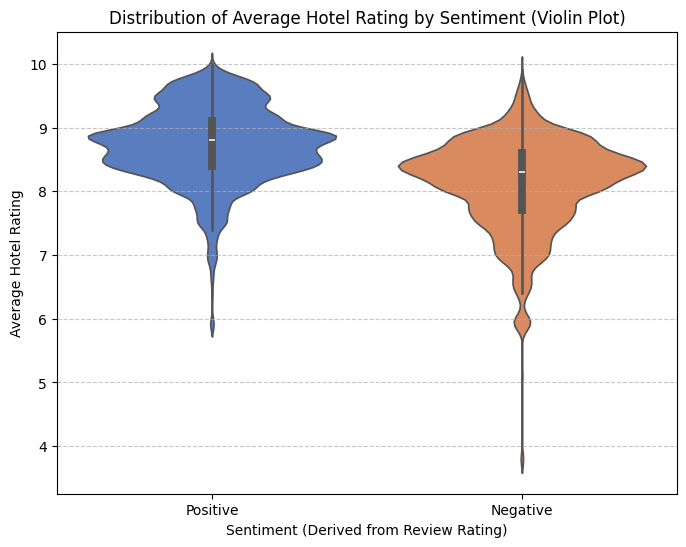

In [189]:
# Evaluating correlation between Sentiment numeric and average rating
if 'sentiment_numeric' not in df_filtered.columns or 'avg_rating' not in df_filtered.columns:
    print("Error: 'sentiment_numeric' or 'avg_rating' columns not found in df_filtered.")
    print("Please ensure df_filtered is correctly set up with these columns before running this code.")
else:
    print("\n--- Calculating Correlation between Sentiment (Numeric) and Average Rating ---")

    # Extract the numeric sentiment (0/1) and the average rating columns
    y_numeric_for_corr = df_filtered['sentiment_numeric']
    avg_rating_for_corr = df_filtered['avg_rating']

    # Calculate Point-Biserial Correlation
    # This function returns a tuple: (correlation_coefficient, p_value)
    correlation, p_value = pointbiserialr(y_numeric_for_corr, avg_rating_for_corr)

    print(f"Point-Biserial Correlation Coefficient: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}") # P-value in scientific notation

    print("\n--- Interpretation ---")
    print(f"The Point-Biserial Correlation coefficient of {correlation:.4f} indicates a strong positive linear relationship between the hotel's average rating and the derived sentiment.")
    print("A positive coefficient means that as the 'avg_rating' increases, the likelihood of a review being classified as 'Positive' (represented by 1) also increases.")
    print("The very low p-value (typically less than 0.05, and here it is extremely small: {:.4e}) suggests that this correlation is statistically highly significant and not due to random chance.".format(p_value))
    print("This quantitative measure reinforces the visual insights from the box/violin plots and strongly supports why 'avg_rating' was a robust and highly influential predictor in your Logistic Regression model.")

    # Displaying visual as they complement the correlation coefficient

    plt.figure(figsize=(8, 6))
    sns.violinplot(x='sentiment_label', y='avg_rating', data=df_filtered, palette='muted')
    plt.title('Distribution of Average Hotel Rating by Sentiment (Violin Plot)')
    plt.xlabel('Sentiment (Derived from Review Rating)')
    plt.ylabel('Average Hotel Rating')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Initial processing to create a ColumTransformer

In [190]:
# Define Feature Sets for ColumnTransformer using df_filtered
text_feature = 'combined_text'
numerical_features = ['avg_rating', 'review_age_days']
categorical_features = ['hotel_name', 'nationality', 'review_month']
target_col = 'sentiment_numeric'

In [191]:
# Create X and y
# Ensure X only contains the features that will be processed by the ColumnTransformer
X = df_filtered[[text_feature] + numerical_features + categorical_features]
y = df_filtered[target_col]

In [192]:
# Splitting data into train and test that will be used for model development, tuning, and initial evaluation
# Then creating a validation set for final evaluation of your single best model
# Step 1: Split data into training set (80%) and a temporary set (20%)
# X_temp will contain the 15% for initial test and 5% for final validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Split the temporary set (X_temp, y_temp) into the Test set (15% of total)
# and the Validation set (5% of total).
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"X_train shape (80%): {X_train.shape}")
print(f"y_train shape (80%): {y_train.shape}")
print(f"X_test shape (15% - for initial model evaluation): {X_test.shape}")
print(f"y_test shape (15% - for initial model evaluation): {y_test.shape}")
print(f"X_val shape (5% - for final best model evaluation): {X_val.shape}")
print(f"y_val shape (5% - for final best model evaluation): {y_val.shape}")
print(f"Features being used: Text: {text_feature}, Numerical: {numerical_features}, Categorical: {categorical_features}")

X_train shape (80%): (21108, 6)
y_train shape (80%): (21108,)
X_test shape (15% - for initial model evaluation): (3958, 6)
y_test shape (15% - for initial model evaluation): (3958,)
X_val shape (5% - for final best model evaluation): (1320, 6)
y_val shape (5% - for final best model evaluation): (1320,)
Features being used: Text: combined_text, Numerical: ['avg_rating', 'review_age_days'], Categorical: ['hotel_name', 'nationality', 'review_month']


In [193]:
#1. Text processing pipeline (for 'combined_text')
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2)))
])

# 2. Numerical processing pipeline
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 3. Categorical processing pipeline
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Combine transformers using ColumnTransformer
preprocessor_final = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_feature),
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print(preprocessor_final)

ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('tfidf',
                                                  TfidfVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'))]),
                                 'combined_text'),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['avg_rating', 'review_age_days']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                            

### Baseline Binary Classification Model

In [194]:
# Logistic Regression Baseline
baseline_pipeline_lr_df_final = Pipeline([
    ('preprocessor', preprocessor_final),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000))
])
baseline_pipeline_lr_df_final.fit(X_train, y_train)
y_pred_lr_df_final = baseline_pipeline_lr_df_final.predict(X_test)
y_prob_lr_df_final = baseline_pipeline_lr_df_final.predict_proba(X_test)[:, 1]

print("\nClassification Report (Logistic Regression Baseline):")
print(classification_report(y_test, y_pred_lr_df_final, target_names=['negative', 'positive']))
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_lr_df_final):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_lr_df_final):.4f}")
print(f"F1-Score (Weighted Avg): {f1_score(y_test, y_pred_lr_df_final, average='weighted'):.4f}") # ADDED LINE


Classification Report (Logistic Regression Baseline):
              precision    recall  f1-score   support

    negative       0.90      0.91      0.90      1809
    positive       0.92      0.91      0.92      2149

    accuracy                           0.91      3958
   macro avg       0.91      0.91      0.91      3958
weighted avg       0.91      0.91      0.91      3958

Accuracy Score: 0.9116
ROC-AUC Score: 0.9710
F1-Score (Weighted Avg): 0.9116


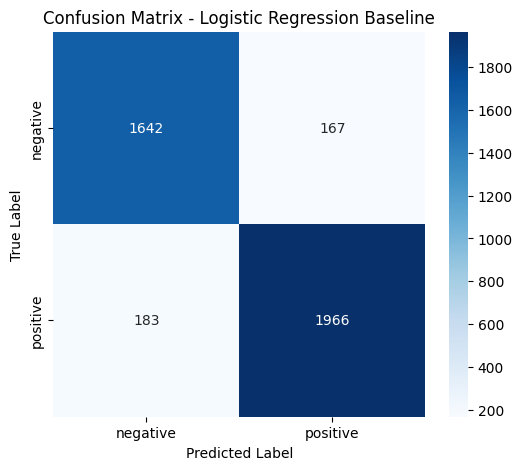

In [195]:
# Confusion Matrix Visualization
cm_lr = confusion_matrix(y_test, y_pred_lr_df_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.title('Confusion Matrix - Logistic Regression Baseline')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

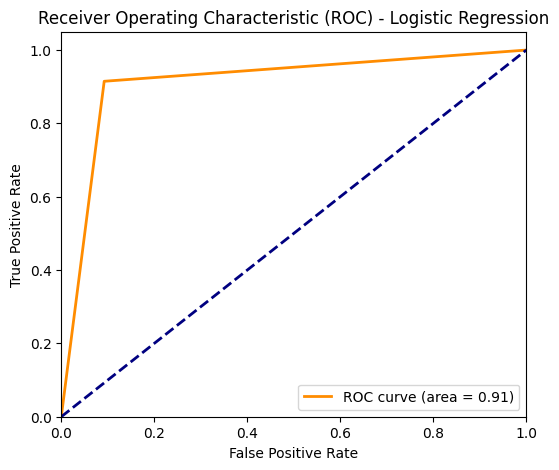

In [196]:
# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_df_final)
plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_lr_df_final):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Before moving forward with further models, I'm going to analyze my current results and refine my current baseline regression pipeline.



#### Deep dive into misclassifications

In [197]:
# Define the mapping from numeric to string sentiment labels for display
sentiment_label_map = {0: 'Negative', 1: 'Positive'}

# Ensure y_test is a Series with the correct index
if not isinstance(y_test, pd.Series):
    y_test_series = pd.Series(y_test, index=X_test.index)
else:
    y_test_series = y_test # It's already a Series with the correct index

# Get indices for each type of classification
true_positives_idx = X_test.index[(y_test_series == 1) & (y_pred_lr_df_final == 1)]
true_negatives_idx = X_test.index[(y_test_series == 0) & (y_pred_lr_df_final == 0)]
false_positives_idx = X_test.index[(y_test_series == 0) & (y_pred_lr_df_final == 1)] # Actual Negative, Predicted Positive
false_negatives_idx = X_test.index[(y_test_series == 1) & (y_pred_lr_df_final == 0)] # Actual Positive, Predicted Negative

print(f"True Positives: {len(true_positives_idx)}")
print(f"True Negatives: {len(true_negatives_idx)}")
print(f"False Positives: {len(false_positives_idx)}")
print(f"False Negatives: {len(false_negatives_idx)}")

True Positives: 1966
True Negatives: 1642
False Positives: 167
False Negatives: 183


In [198]:
# Sample of False Positives (Actual Negative, Predicted Positive)
print("\n Sample of False Positives (Actual Negative, Predicted Positive)")

# Get the review texts using X_test directly
fp_reviews_text = X_test.loc[false_positives_idx, 'combined_text']

# Get the actual numeric sentiment and map to string label
fp_actual_sentiment_numeric = y_test_series.loc[false_positives_idx]
fp_actual_sentiment_str = fp_actual_sentiment_numeric.map(sentiment_label_map)

# Get the predicted numeric sentiment (only for the FP instances) and map to string label
# Need to use the boolean mask to get the corresponding predictions
# FIX: Pass the 'false_positives_idx' to pd.Series constructor
fp_predicted_sentiment_numeric = y_pred_lr_df_final[(y_test_series == 0) & (y_pred_lr_df_final == 1)]
fp_predicted_sentiment_str = pd.Series(fp_predicted_sentiment_numeric, index=false_positives_idx).map(sentiment_label_map)

# Create DataFrame for display
fp_df_display = pd.DataFrame({
    'Review': fp_reviews_text,
    'Actual Sentiment': fp_actual_sentiment_str,
    'Predicted Sentiment': fp_predicted_sentiment_str
})
print(fp_df_display.head(10).to_string())


 Sample of False Positives (Actual Negative, Predicted Positive)
                                                                                                                                                                                                                                                                                                           Review Actual Sentiment Predicted Sentiment
14560  visit enjoy relax stroll de panne need little attention area warm welcome feel.smiling face smile eye weather visit play monopoly bar 13year old afternoon love complimentary crisp belgium beer coke cosy bar area lovely breakfast morning overall lovely xxx break young child triple stay night submit         Negative            Positive
24211                                                                                                                stuff member nice white exclamation mark specifically breakfast fresh juice short glass ware the bienheart exclamation perfect loca

In [199]:
# Sample of False Negatives (Actual Positive, Predicted Negative)
print("\n Sample of False Negatives (Actual Positive, Predicted Negative)")

# Get the review texts using X_test directly
fn_reviews_text = X_test.loc[false_negatives_idx, 'combined_text']

# Get the actual numeric sentiment and map to string label
fn_actual_sentiment_numeric = y_test_series.loc[false_negatives_idx]
fn_actual_sentiment_str = fn_actual_sentiment_numeric.map(sentiment_label_map)

# Get the predicted numeric sentiment (only for the FN instances) and map to string label
# FIX: Pass the 'false_negatives_idx' to pd.Series constructor
fn_predicted_sentiment_numeric = y_pred_lr_df_final[(y_test_series == 1) & (y_pred_lr_df_final == 0)]
fn_predicted_sentiment_str = pd.Series(fn_predicted_sentiment_numeric, index=false_negatives_idx).map(sentiment_label_map)

# Create DataFrame for display
fn_df_display = pd.DataFrame({
    'Review': fn_reviews_text,
    'Actual Sentiment': fn_actual_sentiment_str,
    'Predicted Sentiment': fn_predicted_sentiment_str
})
print(fn_df_display.head(10).to_string())


 Sample of False Negatives (Actual Positive, Predicted Negative)
                                                                                                                                                                                                                                                                                                                                                                                                                                           Review Actual Sentiment Predicted Sentiment
4146                                                                                                                                                                                                                          little sachet soap shampoo mattress staff friendly location bang centre quiet breakfast excellent thing mattress bit soft sachet shower gel soap adequate well environment provide dispenser nice stay night submit         Positive            N

Based on the above examples, I'm going to summarize some findings below:

1. False Positives (Actual Negative, Predicted Positive)

Definition: These are reviews that the model confidently predicted as 'Positive' (rating ≥9.0), but I have label as 'Negative' (rating <9.0).


*   Presence of Strong Positive Language: The most striking pattern is the abundance of highly positive keywords and phrases in these reviews (e.g., "breathtaking view," "excellent standard," "friendly staff," "fabulous," "amazing location," "great pool"). The model trained on these positive indicators, is strongly biased towards predicting 'Positive' when it sees them.


*  Subtle or Accumulating Negatives: Despite the positive language, these reviews often contain clear negative aspects that ultimately led to the lower (negative) rating. These negatives can be:

  - Explicit complaints: "loud neighbour," "wake noise music," "internet_NEG connection_NEG," "door room slow internet."

  - Accumulation of minor inconveniences: Several small issues mentioned together (e.g., coffee machine problems, restaurant closure, advising on planning for public holidays).

  - Problems attributed to external factors but still impacting the stay: "owner guilty_NEG covid- restriction."

*  Model's Blind Spot: The model, being largely a bag-of-words approach, struggles to understand the relative weight of these mixed sentiments. It picks up the strong positives but fails to accurately assess that the listed negatives were significant enough to pull the overall rating below your 9.0 threshold.

2. False Negatives (Actual Positive, Predicted Negative)

Definition: These are reviews that your model predicted as 'Negative' (rating <9.0), but I have label as 'Positive' (rating ≥9.0).

Key Characteristics:



*   Problem Descriptions within Positive Reviews: Many of these reviews discuss specific problems or inconveniences (e.g., "problem stroller new bear stair," "poor water pressure shower," "door lock apartment lock_NEG faulty," "annoying light bathroom," "bathroom leak bathtub," "access car park tricky").

*   Overall Positive Outcome/Feeling: Crucially, despite detailing issues, the reviewers conclude with or frame the experience as overwhelmingly positive. They might mention positive aspects that outweigh the problem, or express satisfaction/willingness to return (e.g., "great exceptional apartment terrace," "nice maintain property general good," "excellent group stay," "amazing staff cool").

*   Model's Blind Spot: The model appears to be overly sensitive to the presence of "problem" words or descriptions of negative events. It flags the review as 'Negative' based on these keywords, failing to recognize the overall positive sentiment and the reviewer's ultimate satisfaction. The human reviewer gave a high rating despite the flaw, indicating the flaw was minor in the grand scheme.

Overall Takeaways for the Model:


*   Mixed Sentiment Challenge: The most significant challenge for the current model lies in handling reviews with mixed sentiments. It struggles to correctly weigh the balance of positive and negative statements when both are present.
*   Nuance and Context: The model finds it difficult to discern subtle nuances, such as when a problem is mentioned but ultimately doesn't detract from a positive experience, or when strong positive words are used in a review that is, overall, dissatisfied.

*   Limitations of Bag-of-Words: While TF-IDF with n-grams captures some context, a simple Logistic Regression model (based on these numerical feature representations) might not fully grasp complex linguistic phenomena like sarcasm, implied sentiment, or the precise interplay of clauses and conjunctions (even with your recent negation refinement, which didn't show a performance shift in this dataset).

This analysis shows that the model is performing well on clear-cut positive or negative reviews, but the "hard cases" are where the true linguistic complexity lies.

To try to solve the above, I'm going to be moving into Hyperparameter Tuning, to try to optimize how the current model balances and weighs all the features it has.

### Hyperparameter Tuning for Logistic Regression and TF-IDF

Building upon othe Baseline Logistic Regression, the current step involves  hyperparameter tuning to optimize the model predictive performance. This process systematically explores various combinations of critical parameters across our entire machine learning pipeline. Specifically, we are tuning the regularization strength (C) of the Logistic Regression classifier, along with key parameters for the TF-IDF Vectorizer such as ngram_range, max_features, min_df, and max_df to refine text representation.

Furthermore, the k parameter for SelectKBest is optimized to determine the ideal number of statistically significant textual features. By employing cross-validation techniques, this exhaustive search aims to identify the optimal parameter configuration that maximizes the model's generalization ability and overall performance metrics on unseen data.

In [200]:
# 1. Define the Pipeline with SelectKBest for Text Features
# We'll re-define the text_transformer to include SelectKBest for tuning its 'k' parameter.
text_transformer_with_selector = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')), # max_features and ngram_range will be tuned
    ('selector', SelectKBest(chi2)) # 'k' will be tuned
])

# Re-create the preprocessor to use the text_transformer with SelectKBest
preprocessor_tuned = ColumnTransformer(
    transformers=[
        ('text', text_transformer_with_selector, text_feature),
        ('num', numerical_transformer, numerical_features), # numerical_transformer defined previously
        ('cat', categorical_transformer, categorical_features) # categorical_transformer defined previously
    ],
    remainder='drop'
)


# Define the full model pipeline for tuning
model_pipeline_for_tuning = Pipeline(steps=[
    ('preprocessor', preprocessor_tuned),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000))
])


In [201]:
# 2. Define the Parameter Search Space
# I will use RandomizedSearchCV for efficiency.
# Adjust the ranges based on your dataset size and computational resources.
# More n_iter will give a more thorough search but take longer.

param_distributions = {
    # Parameters for Logistic Regression Classifier
    'classifier__C': uniform(loc=0.1, scale=100), # C values between 0.1 and 100.1 (stronger to weaker regularization)

    # Parameters for TfidfVectorizer within the 'text' transformer
    'preprocessor__text__tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], # Explore unigrams, bigrams, and trigrams
    'preprocessor__text__tfidf__max_features': randint(5000, 20000), # Number of top features from TFIDF
    'preprocessor__text__tfidf__min_df': randint(1, 10), # Ignore terms appearing in fewer than X documents
    'preprocessor__text__tfidf__max_df': uniform(loc=0.7, scale=0.2), # Ignore terms appearing in more than X% of documents (e.g., 0.7 to 0.9)

    # Parameters for SelectKBest within the 'text' transformer
    # 'k' can be an int (number of features), or 'all'
    'preprocessor__text__selector__k': randint(1000, 10000) # Number of best features to keep after Chi2
}

In [202]:
# These lines are currently commented out because the model took a long time to run
# In this case, I ran the model and then saved the outcome
# To run the model below, you will need to uncomment all the below line
# This step takes a really long time so after running it the next step will be to save it so is easier just to load the data and run the rest of the analysis

# Define custom scorers for multiple metrics
# This dictionary will be used for the 'scoring' parameter in RandomizedSearchCV
#scorers = {
#    'roc_auc': make_scorer(roc_auc_score, needs_proba=True), # Main metric to optimize for
#    'accuracy': make_scorer(accuracy_score),
#    'f1_weighted': make_scorer(f1_score, average='weighted'), # F1-score, weighted by support
#    'f1_macro': make_scorer(f1_score, average='macro')        # F1-score, unweighted average per class
#}

# 3. Set up RandomizedSearchCV
#random_search = RandomizedSearchCV(
#    estimator=model_pipeline_for_tuning,
#    param_distributions=param_distributions,
#    n_iter=50,       # Number of parameter settings to sample. Increase for more exhaustive search.
#    cv=5,            # Number of cross-validation folds.
#    scoring=scorers,
#    refit='roc_auc',
#    random_state=42, # For reproducibility
#    n_jobs=-1,       # Use all available CPU cores
#    verbose=2        # Output verbosity (0 for silent, 1 for progress, 2 for detailed)
#)


# Fit the RandomizedSearchCV object to your training data
#random_search.fit(X_train, y_train)

In [203]:
#To run the code below, you will need to uncomment the code by removing the # symbol.

# Saving model
#Create a local directory
#local_save_dir = '/content/downloaded_models'
#os.makedirs(local_save_dir, exist_ok=True)

#Define the full path for your saved model file
#model_filename = os.path.join(local_save_dir, 'random_search_3.joblib')

# Save the entire RandomizedSearchCV object
#joblib.dump(random_search, model_filename)

#print(f"Tuned Baseline model saved locally to: {model_filename}")

In [204]:
# Downloading the model previously saved and uploaded into Kaggle datasets
! kaggle datasets download -d karinabe25us/random-search-3
! unzip random-search-3.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/random-search-3
License(s): apache-2.0
random-search-3.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  random-search-3.zip
replace random_search_3.joblib? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: random_search_3.joblib  


In [205]:
y# Loading the model for analysis
model_file_path = '/content/random_search_3.joblib'

# Load the entire RandomizedSearchCV object
random_search = joblib.load(model_file_path)

In [206]:
# 4. Display Best Parameters and Score
print("\n--- Hyperparameter Tuning Results ---")
print("Best parameters found: ", random_search.best_params_)
print(f"Best ROC-AUC score (cross-validation): {random_search.best_score_:.4f}")


--- Hyperparameter Tuning Results ---
Best parameters found:  {'classifier__C': np.float64(37.55401188473625), 'preprocessor__text__selector__k': 1860, 'preprocessor__text__tfidf__max_df': np.float64(0.7366869579732327), 'preprocessor__text__tfidf__max_features': 10191, 'preprocessor__text__tfidf__min_df': 5, 'preprocessor__text__tfidf__ngram_range': (1, 3)}
Best ROC-AUC score (cross-validation): nan


In [207]:
# 5. Evaluate the Best Model on the Test Set
print("\n--- Evaluating Best Model from RandomizedSearchCV on Test Set ---")
best_model = random_search.best_estimator_

y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1] # Probabilities for ROC curve

print("\nClassification Report (Best Tuned Model):\n", classification_report(y_test, y_pred_best, target_names=['negative', 'positive']))
print(f"Accuracy Score (Best Tuned Model): {accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC Score (Best Tuned Model): {roc_auc_score(y_test, y_pred_proba_best):.4f}")
print(f"F1-Score (Weighted Avg): {f1_score(y_test, y_pred_best, average='weighted'):.4f}")


--- Evaluating Best Model from RandomizedSearchCV on Test Set ---

Classification Report (Best Tuned Model):
               precision    recall  f1-score   support

    negative       0.90      0.90      0.90      1809
    positive       0.91      0.91      0.91      2149

    accuracy                           0.91      3958
   macro avg       0.91      0.91      0.91      3958
weighted avg       0.91      0.91      0.91      3958

Accuracy Score (Best Tuned Model): 0.9070
ROC-AUC Score (Best Tuned Model): 0.9692
F1-Score (Weighted Avg): 0.9070


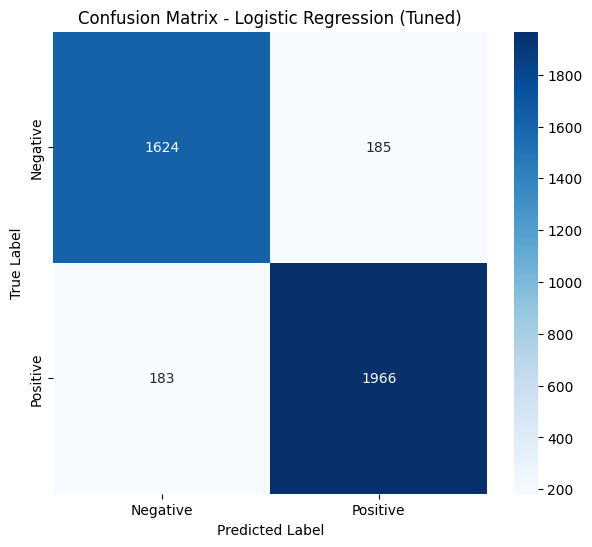

In [208]:
# 6. Plot Confusion Matrix for Best Tuned Model
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Logistic Regression (Tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

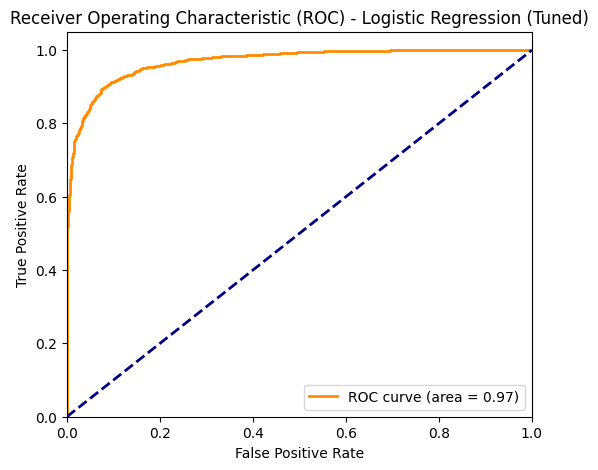

In [209]:
# 7. Plot ROC Curve for Best Tuned Model
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)
plt.figure(figsize=(6, 5))
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_proba_best):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression (Tuned)')
plt.legend(loc="lower right")
plt.show()

### Advanced Machine learning Models

#### Supprt Vector Machine (SVC) Classifier

SVMs are powerful for high-dimensional data, common with TF-IDF, by finding optimal separation hyperplanes.



In [210]:
# 1. Define SVM Pipeline
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tuned),
    ('classifier', SVC(random_state=42, probability=True))
])

In [211]:
# 2. Define Parameter Search Space for SVM
param_distributions_svm = {
    'classifier__C': uniform(loc=0.1, scale=10), # Typically between 0.1 and 100 for text
    'classifier__kernel': ['linear', 'rbf'], # Linear often performs well on sparse text data
    'classifier__gamma': ['scale', 'auto'] # Kernel coefficient, 'scale' is default
}

In [212]:
# These lines are currently commented out because the model took a long time to run
# In this case, I ran the model and then saved the outcome
# To run the model below, you will need to uncomment all the below line
# This step takes a really long time so after running it the next step will be to save it so is easier just to load the data and run the rest of the analysis

# Define custom scorers for multiple metrics
# This dictionary will be used for the 'scoring' parameter in RandomizedSearchCV
#scorers = {
#    'roc_auc': make_scorer(roc_auc_score, needs_proba=True), # Main metric to optimize for
#    'accuracy': make_scorer(accuracy_score),
#    'f1_weighted': make_scorer(f1_score, average='weighted'), # F1-score, weighted by support
#    'f1_macro': make_scorer(f1_score, average='macro')        # F1-score, unweighted average per class
#}

# 3. Perform Hyperparameter Tuning for SVM
# n_iter should be adjusted based on computational resources
#random_search_svm = RandomizedSearchCV(
#    estimator=svm_pipeline,
#    param_distributions=param_distributions_svm,
#    n_iter=20, # Reduced for initial exploration, increase for more thorough search
#    cv=3,       # Reduced CV folds for faster initial exploration
#    scoring=scorers,
#    refit='roc_auc',
#    random_state=42,
#    n_jobs=-1,
#    verbose=2
#)

#random_search_svm.fit(X_train, y_train)

In [213]:
# Saving model
# Create a local directory
#local_save_dir = '/content/downloaded_models'
#os.makedirs(local_save_dir, exist_ok=True)

# Define the full path for your saved model file
#model_filename = os.path.join(local_save_dir, 'random_search_svm_2.joblib')

# Save the entire RandomizedSearchCV object
#joblib.dump(random_search_svm, model_filename)

#print(f"Tuned SVC model saved locally to: {model_filename}")

In [214]:
# Downloading the model previously saved and uploaded into Kaggle datasets
! kaggle datasets download -d karinabe25us/random-search-svm-2
! unzip random-search-svm-2.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/random-search-svm-2
License(s): apache-2.0
random-search-svm-2.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  random-search-svm-2.zip
replace random_search_svm_2.joblib? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: random_search_svm_2.joblib  


In [215]:
# Loading the model for analysis
model_file_path = '/content/random_search_svm_2.joblib'

# Load the entire RandomizedSearchCV object
random_search_svm = joblib.load(model_file_path)

In [216]:
# 4. Display Best Parameters and Score for SVM
print("\n--- SVM Hyperparameter Tuning Results ---")
print("Best parameters found: ", random_search_svm.best_params_)
print(f"Best ROC-AUC score (cross-validation): {random_search_svm.best_score_:.4f}")


--- SVM Hyperparameter Tuning Results ---
Best parameters found:  {'classifier__C': np.float64(3.845401188473625), 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best ROC-AUC score (cross-validation): nan


In [217]:
# 5. Evaluate the Best SVM Model on the Test Set
print("\n--- Evaluating Best SVM Model on Test Set ---")
best_svm_model = random_search_svm.best_estimator_

y_pred_svm = best_svm_model.predict(X_test)
y_pred_proba_svm = best_svm_model.predict_proba(X_test)[:, 1]

print("\nClassification Report (Best Tuned SVM Model):\n", classification_report(y_test, y_pred_svm, target_names=['negative', 'positive']))
print(f"Accuracy Score (Best Tuned SVM Model): {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"ROC-AUC Score (Best Tuned SVM Model): {roc_auc_score(y_test, y_pred_proba_svm):.4f}")
print(f"F1-Score (Weighted Avg): {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")


--- Evaluating Best SVM Model on Test Set ---

Classification Report (Best Tuned SVM Model):
               precision    recall  f1-score   support

    negative       0.84      0.90      0.87      1809
    positive       0.91      0.86      0.89      2149

    accuracy                           0.88      3958
   macro avg       0.88      0.88      0.88      3958
weighted avg       0.88      0.88      0.88      3958

Accuracy Score (Best Tuned SVM Model): 0.8797
ROC-AUC Score (Best Tuned SVM Model): 0.9491
F1-Score (Weighted Avg): 0.8799


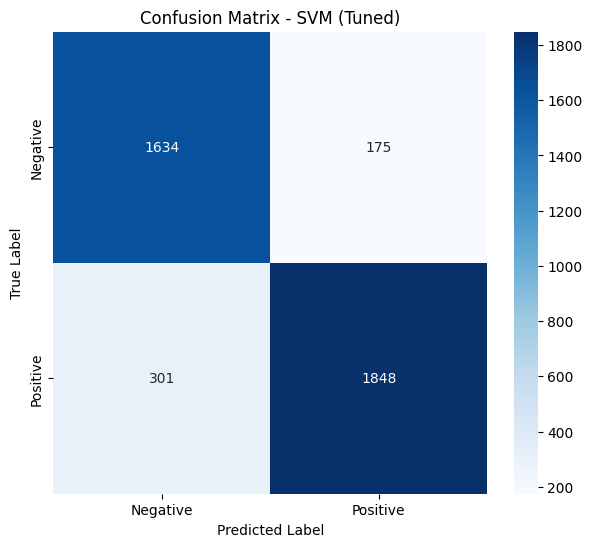

In [218]:
# Plot Confusion Matrix for Best SVM Model
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - SVM (Tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

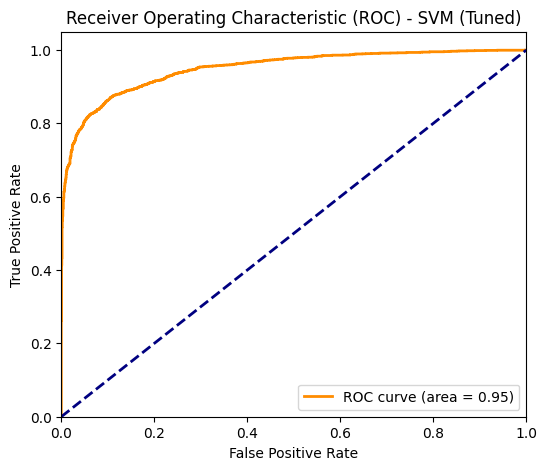

In [219]:
# Plot ROC Curve for Best SVM Model
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
plt.figure(figsize=(6, 5))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_proba_svm):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - SVM (Tuned)')
plt.legend(loc="lower right")
plt.show()

#### LightGBM (LGBM) Classifier

LightGBM is a highly efficient and effective gradient boosting framework that often outperforms other GBMs in terms of speed and accuracy, especially with large datasets.

In [220]:
# 1. Define LightGBM Pipeline
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tuned),
    ('classifier', LGBMClassifier(random_state=42))
])

In [221]:
# 2. Define Parameter Search Space for LightGBM
param_distributions_lgbm = {
    'classifier__n_estimators': randint(100, 500), # Number of boosting stages
    'classifier__learning_rate': uniform(loc=0.01, scale=0.2), # Step size shrinkage
    'classifier__num_leaves': randint(20, 60), # Max tree leaves for base learners
    'classifier__max_depth': randint(5, 15), # Max tree depth
    'classifier__reg_alpha': uniform(loc=0, scale=0.5), # L1 regularization
    'classifier__reg_lambda': uniform(loc=0, scale=0.5), # L2 regularization
    'classifier__colsample_bytree': uniform(loc=0.6, scale=0.4), # Subsample ratio of columns when constructing each tree
    'classifier__subsample': uniform(loc=0.6, scale=0.4), # Subsample ratio of the training instance
}

In [222]:
# Define custom scorers for multiple metrics
# This dictionary will be used for the 'scoring' parameter in RandomizedSearchCV
#scorers = {
#    'roc_auc': make_scorer(roc_auc_score, needs_proba=True), # Main metric to optimize for
#    'accuracy': make_scorer(accuracy_score),
#    'f1_weighted': make_scorer(f1_score, average='weighted'), # F1-score, weighted by support
#    'f1_macro': make_scorer(f1_score, average='macro')        # F1-score, unweighted average per class
#}


# 3. Perform Hyperparameter Tuning for LightGBM
#random_search_lgbm = RandomizedSearchCV(
#    estimator=lgbm_pipeline,
#    param_distributions=param_distributions_lgbm,
#    n_iter=30, # More iterations for GBMs can be beneficial
#    cv=3,
#    scoring=scorers,
#    refit='roc_auc',
#    random_state=42,
#    n_jobs=-1,
#    verbose=2
#)

#random_search_lgbm.fit(X_train, y_train)

In [223]:
# Saving model
# Create a local directory if it doesn't exist
#local_save_dir = '/content/downloaded_models'
#os.makedirs(local_save_dir, exist_ok=True)

# Define the full path for your saved model file
#model_filename = os.path.join(local_save_dir, 'random_search_lgbm_1.joblib')

# Save the entire RandomizedSearchCV object
#joblib.dump(random_search_lgbm, model_filename)

#print(f"Tuned LightGBM model saved locally to: {model_filename}")


In [224]:
# Downloading the model previously saved and uploaded into Kaggle datasets
! kaggle datasets download -d karinabe25us/random-search-lgbm-1
! unzip random-search-lgbm-1.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/random-search-lgbm-1
License(s): apache-2.0
random-search-lgbm-1.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  random-search-lgbm-1.zip
replace random_search_lgbm_1.joblib? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: random_search_lgbm_1.joblib  


In [225]:
# Loading the model for analysis
model_file_path = '/content/random_search_lgbm_1.joblib'

# Load the entire RandomizedSearchCV object
random_search_lgbm = joblib.load(model_file_path)

In [226]:
# 4. Display Best Parameters and Score for LightGBM
print("\n--- LightGBM Hyperparameter Tuning Results ---")
print("Best parameters found: ", random_search_lgbm.best_params_)
print(f"Best ROC-AUC score (cross-validation): {random_search_lgbm.best_score_:.4f}")


--- LightGBM Hyperparameter Tuning Results ---
Best parameters found:  {'classifier__colsample_bytree': np.float64(0.749816047538945), 'classifier__learning_rate': np.float64(0.20014286128198325), 'classifier__max_depth': 12, 'classifier__n_estimators': 288, 'classifier__num_leaves': 40, 'classifier__reg_alpha': np.float64(0.07800932022121826), 'classifier__reg_lambda': np.float64(0.07799726016810132), 'classifier__subsample': np.float64(0.6232334448672797)}
Best ROC-AUC score (cross-validation): nan


In [227]:
# 5. Evaluate the Best LightGBM Model on the Test Set
print("\n--- Evaluating Best LightGBM Model on Test Set ---")
best_lgbm_model = random_search_lgbm.best_estimator_

y_pred_lgbm = best_lgbm_model.predict(X_test)
y_pred_proba_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]

print("\nClassification Report (Best Tuned LightGBM Model):\n", classification_report(y_test, y_pred_lgbm, target_names=['negative', 'positive']))
print(f"Accuracy Score (Best Tuned LightGBM Model): {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(f"ROC-AUC Score (Best Tuned LightGBM Model): {roc_auc_score(y_test, y_pred_proba_lgbm):.4f}")
print(f"F1-Score (Weighted Avg): {f1_score(y_test, y_pred_lgbm, average='weighted'):.4f}")


--- Evaluating Best LightGBM Model on Test Set ---

Classification Report (Best Tuned LightGBM Model):
               precision    recall  f1-score   support

    negative       0.86      0.88      0.87      1809
    positive       0.90      0.88      0.89      2149

    accuracy                           0.88      3958
   macro avg       0.88      0.88      0.88      3958
weighted avg       0.88      0.88      0.88      3958

Accuracy Score (Best Tuned LightGBM Model): 0.8775
ROC-AUC Score (Best Tuned LightGBM Model): 0.9531
F1-Score (Weighted Avg): 0.8776


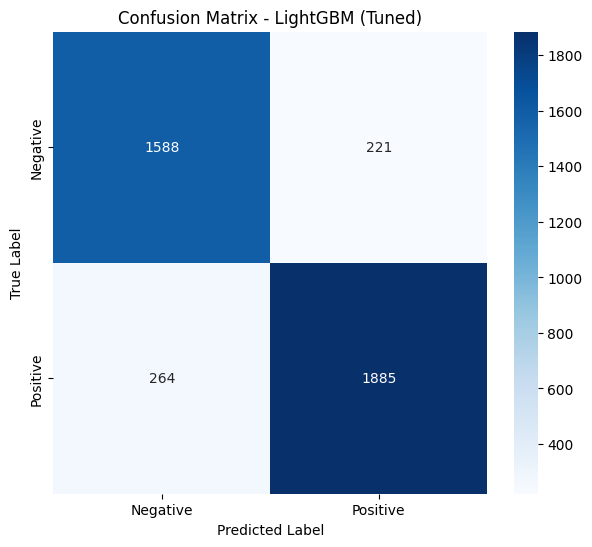

In [228]:
# Plot Confusion Matrix for Best LightGBM Model
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - LightGBM (Tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

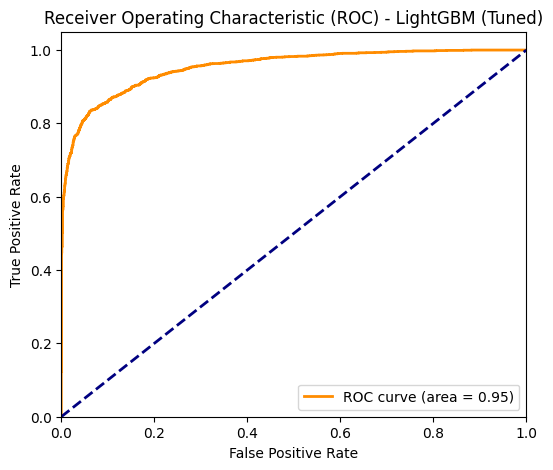

In [229]:
# Plot ROC Curve for Best LightGBM Model
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
plt.figure(figsize=(6, 5))
plt.plot(fpr_lgbm, tpr_lgbm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_proba_lgbm):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - LightGBM (Tuned)')
plt.legend(loc="lower right")
plt.show()

#### Random Forest Classifier

Random Forests are versatile, robust to overfitting, and can capture non-linear relationships, making them a solid choice for a comparative benchmark.

In [230]:
# 1. Define Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tuned),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [231]:
# 2. Define Parameter Search Space for Random Forest
param_distributions_rf = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': randint(10, 30),
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 5),
    'classifier__bootstrap': [True, False]
}

In [232]:
# Define custom scorers for multiple metrics
# This dictionary will be used for the 'scoring' parameter in RandomizedSearchCV
#scorers = {
#    'roc_auc': make_scorer(roc_auc_score, needs_proba=True), # Main metric to optimize for
#    'accuracy': make_scorer(accuracy_score),
#    'f1_weighted': make_scorer(f1_score, average='weighted'), # F1-score, weighted by support
#    'f1_macro': make_scorer(f1_score, average='macro')        # F1-score, unweighted average per class
#}

# 3. Perform Hyperparameter Tuning for Random Forest
#random_search_rf = RandomizedSearchCV(
#    estimator=rf_pipeline,
#    param_distributions=param_distributions_rf,
#    n_iter=30, # Can be resource intensive, so change as needed
#    cv=3,
#    scoring=scorers,
#    refit='roc_auc',
#    random_state=42,
#    n_jobs=-1,
#    verbose=2
#)

#random_search_rf.fit(X_train, y_train)

In [233]:
# Saving model
# Create a local directory if it doesn't exist
#local_save_dir = '/content/downloaded_models'
#os.makedirs(local_save_dir, exist_ok=True)

# Define the full path for your saved model file
#model_filename = os.path.join(local_save_dir, 'random_search_rf_1.joblib')
#joblib.dump(random_search_rf, model_filename)

#print(f"Tuned Random Forest Classifier saved locally to: {model_filename}")

In [234]:
# Downloading the model previously saved and uploaded into Kaggle datasets
! kaggle datasets download -d karinabe25us/random-search-rf-1
! unzip random-search-rf-1.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/random-search-rf-1
License(s): apache-2.0
random-search-rf-1.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  random-search-rf-1.zip
replace random_search_rf_1.joblib? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: random_search_rf_1.joblib  


In [235]:
# Loading the model for analysis
model_file_path = '/content/random_search_rf_1.joblib'

# Load the entire RandomizedSearchCV object
random_search_rf = joblib.load(model_file_path)

In [236]:
# 4. Display Best Parameters and Score for Random Forest
print("\n--- Random Forest Hyperparameter Tuning Results ---")
print("Best parameters found: ", random_search_rf.best_params_)
print(f"Best ROC-AUC score (cross-validation): {random_search_rf.best_score_:.4f}")


--- Random Forest Hyperparameter Tuning Results ---
Best parameters found:  {'classifier__bootstrap': True, 'classifier__max_depth': 29, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 171}
Best ROC-AUC score (cross-validation): nan


In [237]:
# 5. Evaluate the Best Random Forest Model on the Test Set
print("\n--- Evaluating Best Random Forest Model on Test Set ---")
best_rf_model = random_search_rf.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)
y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report (Best Tuned Random Forest Model):\n", classification_report(y_test, y_pred_rf, target_names=['negative', 'positive']))
print(f"Accuracy Score (Best Tuned Random Forest Model): {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC Score (Best Tuned Random Forest Model): {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"F1-Score (Weighted Avg): {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")


--- Evaluating Best Random Forest Model on Test Set ---

Classification Report (Best Tuned Random Forest Model):
               precision    recall  f1-score   support

    negative       0.85      0.91      0.88      1809
    positive       0.92      0.86      0.89      2149

    accuracy                           0.88      3958
   macro avg       0.88      0.89      0.88      3958
weighted avg       0.89      0.88      0.88      3958

Accuracy Score (Best Tuned Random Forest Model): 0.8830
ROC-AUC Score (Best Tuned Random Forest Model): 0.9499
F1-Score (Weighted Avg): 0.8832


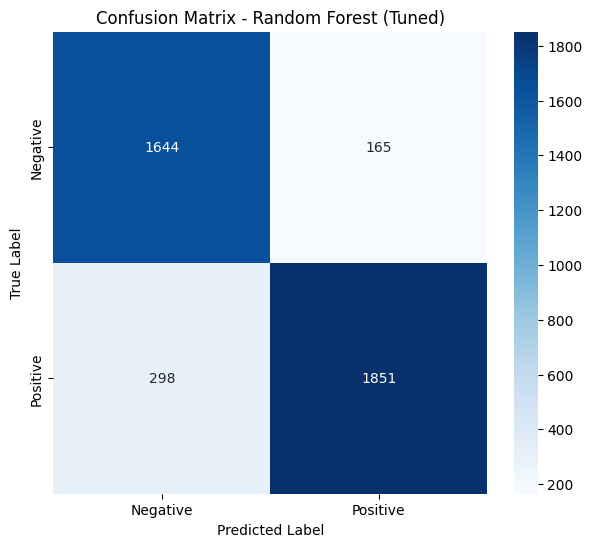

In [238]:
# Plot Confusion Matrix for Best Random Forest Model
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

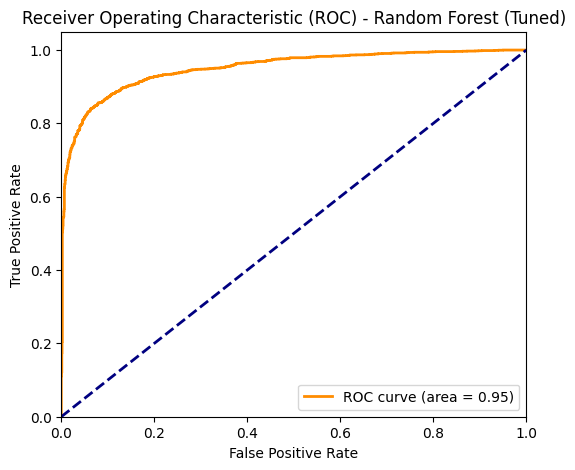

In [239]:
# Plot ROC Curve for Best Random Forest Model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_proba_rf):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest (Tuned)')
plt.legend(loc="lower right")
plt.show()

## Model Evaluation

In [240]:
# --- Capture metrics for Logistic Regression ---
accuracy_lr = accuracy_score(y_test, y_pred_best)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_best)
class_report_lr = classification_report(y_test, y_pred_best, target_names=['negative', 'positive'], output_dict=True)
f1_neg_lr = class_report_lr['negative']['f1-score']
f1_pos_lr = class_report_lr['positive']['f1-score']
f1_weighted_lr = class_report_lr['weighted avg']['f1-score'] # CAPTURE WEIGHTED F1
cm_lr = confusion_matrix(y_test, y_pred_best)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()

# --- Capture metrics for SVM ---
accuracy_svm = accuracy_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
class_report_svm = classification_report(y_test, y_pred_svm, target_names=['negative', 'positive'], output_dict=True)
f1_neg_svm = class_report_svm['negative']['f1-score']
f1_pos_svm = class_report_svm['positive']['f1-score']
f1_weighted_svm = class_report_svm['weighted avg']['f1-score'] # CAPTURE WEIGHTED F1
cm_svm = confusion_matrix(y_test, y_pred_svm)
tn_svm, fp_svm, fn_svm, tp_svm = cm_svm.ravel()

# --- Capture metrics for LightGBM ---
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
class_report_lgbm = classification_report(y_test, y_pred_lgbm, target_names=['negative', 'positive'], output_dict=True)
f1_neg_lgbm = class_report_lgbm['negative']['f1-score']
f1_pos_lgbm = class_report_lgbm['positive']['f1-score']
f1_weighted_lgbm = class_report_lgbm['weighted avg']['f1-score'] # CAPTURE WEIGHTED F1
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
tn_lgbm, fp_lgbm, fn_lgbm, tp_lgbm = cm_lgbm.ravel()

# --- Capture metrics for Random Forest ---
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
class_report_rf = classification_report(y_test, y_pred_rf, target_names=['negative', 'positive'], output_dict=True)
f1_neg_rf = class_report_rf['negative']['f1-score']
f1_pos_rf = class_report_rf['positive']['f1-score']
f1_weighted_rf = class_report_rf['weighted avg']['f1-score'] # CAPTURE WEIGHTED F1
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()


# --- Create a dictionary to hold all results (now including CM counts) ---
results_data = {
    'Model': [
        'Tuned Logistic Regression',
        'Tuned LightGBM',
        'Tuned Random Forest',
        'Tuned SVM'
    ],
    'Accuracy': [
        accuracy_lr,
        accuracy_lgbm,
        accuracy_rf,
        accuracy_svm
    ],
    'ROC-AUC': [
        roc_auc_lr,
        roc_auc_lgbm,
        roc_auc_rf,
        roc_auc_svm
    ],
    'Negative F1': [
        f1_neg_lr,
        f1_neg_lgbm,
        f1_neg_rf,
        f1_neg_svm
    ],
    'Positive F1': [
        f1_pos_lr,
        f1_pos_lgbm,
        f1_pos_rf,
        f1_pos_svm
    ],
    'Weighted F1': [ # ADDED THIS COLUMN
        f1_weighted_lr,
        f1_weighted_lgbm,
        f1_weighted_rf,
        f1_weighted_svm
    ],
    'True Negatives (TN)': [
        tn_lr,
        tn_lgbm,
        tn_rf,
        tn_svm
    ],
    'False Positives (FP)': [
        fp_lr,
        fp_lgbm,
        fp_rf,
        fp_svm
    ],
    'False Negatives (FN)': [
        fn_lr,
        fn_lgbm,
        fn_rf,
        fn_svm
    ],
    'True Positives (TP)': [
        tp_lr,
        tp_lgbm,
        tp_rf,
        tp_svm
    ]
}

# Create a DataFrame
results_df = pd.DataFrame(results_data)

# Sort by ROC-AUC (or Accuracy) to easily see the best performing model
results_df_sorted = results_df.sort_values(by='ROC-AUC', ascending=False)

# Convert to HTML and print
html_output = results_df_sorted.to_html(index=False)
display(HTML(html_output))

Model,Accuracy,ROC-AUC,Negative F1,Positive F1,Weighted F1,True Negatives (TN),False Positives (FP),False Negatives (FN),True Positives (TP)
Tuned Logistic Regression,0.907024,0.969212,0.898230,0.914419,0.907020,1624,185,183,1966
Tuned LightGBM,0.877463,0.953114,0.867523,0.886016,0.877564,1588,221,264,1885
Tuned Random Forest,0.883022,0.949918,0.876566,0.888836,0.883228,1644,165,298,1851
Tuned SVM,0.879737,0.949090,0.872863,0.885906,0.879945,1634,175,301,1848


ADD description of results and choosing the best model and why?
Explain why the tuned logistic regression might be the best model even with the advanced models.

###  In-Depth Error Analysis (Revisit for Tuned LR - Final Pass)

Crucial to understand why is this the best model

In [241]:
# Ensure y_test is a Series with the correct index for slicing
if not isinstance(y_test, pd.Series):
    y_test_series = pd.Series(y_test, index=X_test.index)
else:
    y_test_series = y_test

# Define the mapping from numeric to string sentiment labels for display
sentiment_label_map = {0: 'Negative', 1: 'Positive'}

# Get indices for each type of classification using the TUNED model's predictions
true_positives_idx = X_test.index[(y_test_series == 1) & (y_pred_best == 1)]
true_negatives_idx = X_test.index[(y_test_series == 0) & (y_pred_best == 0)]
false_positives_idx = X_test.index[(y_test_series == 0) & (y_pred_best == 1)] # Actual Negative, Predicted Positive
false_negatives_idx = X_test.index[(y_test_series == 1) & (y_pred_best == 0)] # Actual Positive, Predicted Negative

print(f"True Positives (Tuned LR): {len(true_positives_idx)}")
print(f"True Negatives (Tuned LR): {len(true_negatives_idx)}")
print(f"False Positives (Tuned LR): {len(false_positives_idx)}")
print(f"False Negatives (Tuned LR): {len(false_negatives_idx)}")


# --- Sample of False Positives (Actual Negative, Predicted Positive) for Tuned LR ---
print("\n--- Sample of False Positives (Actual Negative, Predicted Positive) for Tuned LR ---")
fp_reviews_text = X_test.loc[false_positives_idx, 'combined_text']
fp_actual_sentiment_numeric = y_test_series.loc[false_positives_idx]
fp_actual_sentiment_str = fp_actual_sentiment_numeric.map(sentiment_label_map)
fp_predicted_sentiment_numeric = y_pred_best[(y_test_series == 0) & (y_pred_best == 1)]
fp_predicted_sentiment_str = pd.Series(fp_predicted_sentiment_numeric, index=false_positives_idx).map(sentiment_label_map)

fp_df_display = pd.DataFrame({
    'Review': fp_reviews_text,
    'Actual Sentiment': fp_actual_sentiment_str,
    'Predicted Sentiment': fp_predicted_sentiment_str
})
print(fp_df_display.head(10).to_string())


# --- Sample of False Negatives (Actual Positive, Predicted Negative) for Tuned LR ---
print("\n--- Sample of False Negatives (Actual Positive, Predicted Negative) for Tuned LR ---")
fn_reviews_text = X_test.loc[false_negatives_idx, 'combined_text']
fn_actual_sentiment_numeric = y_test_series.loc[false_negatives_idx]
fn_actual_sentiment_str = fn_actual_sentiment_numeric.map(sentiment_label_map)
fn_predicted_sentiment_numeric = y_pred_best[(y_test_series == 1) & (y_pred_best == 0)]
fn_predicted_sentiment_str = pd.Series(fn_predicted_sentiment_numeric, index=false_negatives_idx).map(sentiment_label_map)

fn_df_display = pd.DataFrame({
    'Review': fn_reviews_text,
    'Actual Sentiment': fn_actual_sentiment_str,
    'Predicted Sentiment': fn_predicted_sentiment_str
})
print(fn_df_display.head(10).to_string())


True Positives (Tuned LR): 1966
True Negatives (Tuned LR): 1624
False Positives (Tuned LR): 185
False Negatives (Tuned LR): 183

--- Sample of False Positives (Actual Negative, Predicted Positive) for Tuned LR ---
                                                                                                                                                                                                                                                                                                           Review Actual Sentiment Predicted Sentiment
23861                                                                                             warn stair like climb north face tiger reasonably agile stair steep multiple flight electrical socket check appear loose comfortable bed sofa great location christmas market superior studio stay night submit         Negative            Positive
14560  visit enjoy relax stroll de panne need little attention area warm welcome feel.smiling face s

Following hyperparameter tuning, our Logistic Regression model demonstrated a modest yet significant improvement in overall performance metrics, including accuracy and ROC-AUC. However, a detailed error analysis revealed persistent misclassification patterns, particularly concerning reviews with mixed sentiments. False positives frequently occurred when reviews contained prominent positive keywords, which the model prioritized over more nuanced or accumulated negative details that led to an overall low rating. Conversely, false negatives arose when genuinely positive reviews discussed minor issues or inconveniences, causing the model to incorrectly predict a negative sentiment despite the reviewer's clear satisfaction. This suggests that while our tuned model excels at identifying explicit sentiment, it struggles with the intricate contextual understanding, relative weighting of conflicting information, and subtle nuances inherent in human language that define these challenging mixed-sentiment cases.

Based on this our next step will be deep learning for text classification

### Feature Importance (for Tuned LR)

In [242]:
# Get the preprocessor step
preprocessor_step = best_model.named_steps['preprocessor']

# Get the classifier step
classifier = best_model.named_steps['classifier']

# Get the fitted TfidfVectorizer from the 'text' transformer
tfidf_vectorizer = preprocessor_step.named_transformers_['text'].named_steps['tfidf']

# Get the fitted SelectKBest from the 'text' transformer
text_selector = preprocessor_step.named_transformers_['text'].named_steps['selector']

# Get the feature names for the TF-IDF part *after* selection
text_feature_names = tfidf_vectorizer.get_feature_names_out()
selected_tfidf_features = [text_feature_names[i] for i in text_selector.get_support(indices=True)]

# Get the fitted StandardScaler for numerical features (from the 'num' transformer)
numerical_scaler_pipeline = preprocessor_step.named_transformers_['num']
# Numerical features are just their names
numerical_feature_names = numerical_features

# Get the fitted OneHotEncoder for categorical features (from the 'cat' transformer)
categorical_encoder_pipeline = preprocessor_step.named_transformers_['cat']
encoded_categorical_features = list(categorical_encoder_pipeline.named_steps['onehot'].get_feature_names_out(categorical_features))

In [243]:
# Combine all feature names in the order they appear in the transformed output
all_feature_names = selected_tfidf_features + numerical_feature_names + encoded_categorical_features

# Get the coefficients from the Logistic Regression model
coefficients = classifier.coef_[0]

# Create a DataFrame for all feature importances
all_feature_importances = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients
})

# Sort and display top positive and negative coefficients
top_positive_coeffs = all_feature_importances.sort_values(by='coefficient', ascending=False).head(20)
print("\n--- Top 20 features most indicative of POSITIVE sentiment (highest positive coefficients) - Tuned LR ---")
for _, row in top_positive_coeffs.iterrows():
    print(f"{row['feature']:<40} {row['coefficient']:.6f}")

top_negative_coeffs = all_feature_importances.sort_values(by='coefficient', ascending=True).head(20)
print("\n--- Top 20 features most indicative of NEGATIVE sentiment (most negative coefficients) - Tuned LR ---")
for _, row in top_negative_coeffs.iterrows():
    print(f"{row['feature']:<40} {row['coefficient']:.6f}")


--- Top 20 features most indicative of POSITIVE sentiment (highest positive coefficients) - Tuned LR ---
exceptional                              34.199716
superb                                   28.957921
exceptional standard                     10.653258
superb standard                          10.420079
superb group                             10.400723
exceptional young                        10.035302
exceptional young child                  10.035302
restaurant excellent                     9.977212
exceptional group                        9.888180
superb friend                            9.119317
nationality_Cameroon                     8.637829
plentiful                                8.403113
superb young                             8.324074
superb young child                       8.324074
exceptional superior                     8.245056
exceptional friend                       8.020591
answer question                          7.776296
perfect apartment                    

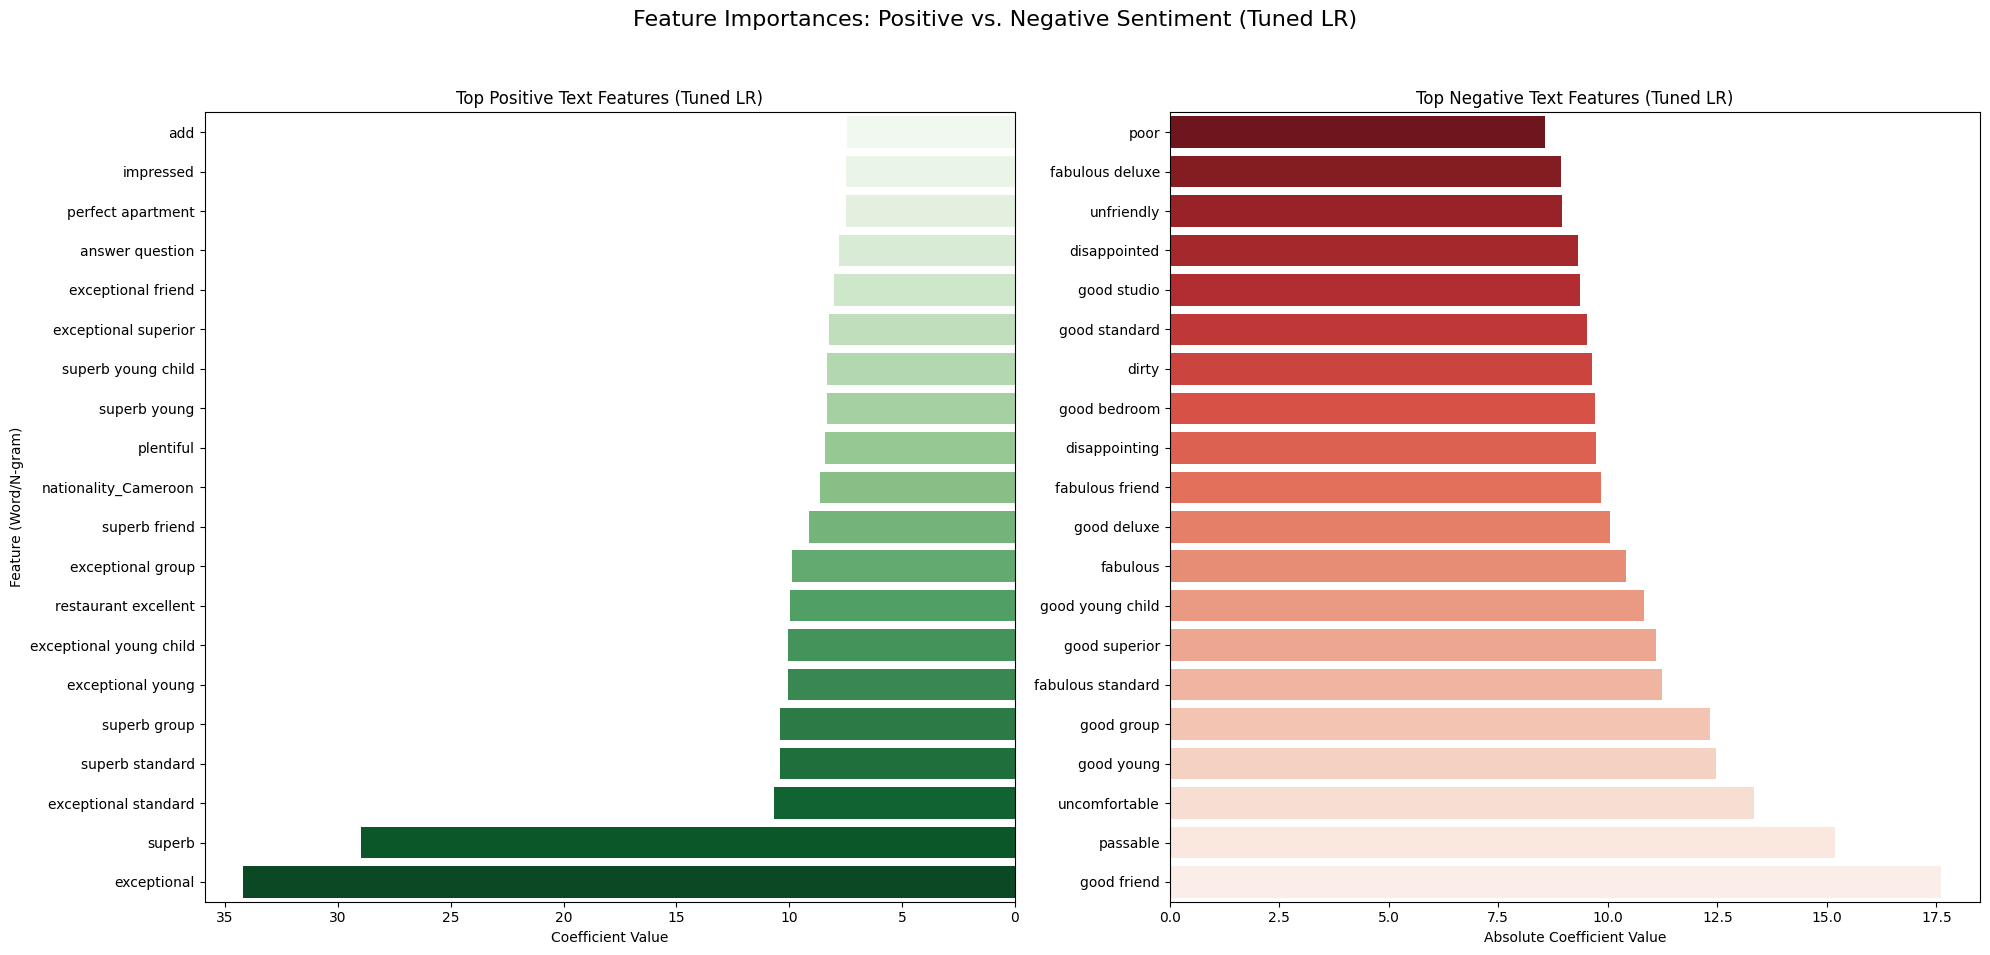

In [244]:
# CHANGE this code
# Creating a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot Top Positive Text Features (Left Subplot) ---
sns.barplot(x='coefficient', y='feature', data=top_positive_coeffs, palette='Greens_r', ax=axes[0]) # '_r' reverses the palette
axes[0].set_title('Top Positive Text Features (Tuned LR)')
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Feature (Word/N-gram)')
axes[0].invert_xaxis()
axes[0].invert_yaxis()


# Plot Top Negative Text Features (Right Subplot) ---
top_negative_text_coeffs_abs = top_negative_coeffs.copy()
top_negative_text_coeffs_abs['coefficient'] = top_negative_text_coeffs_abs['coefficient'].abs()

top_negative_text_coeffs_abs = top_negative_text_coeffs_abs.sort_values(by='coefficient', ascending=False)

sns.barplot(x='coefficient', y='feature', data=top_negative_text_coeffs_abs, palette='Reds', ax=axes[1])
axes[1].set_title('Top Negative Text Features (Tuned LR)')
axes[1].set_xlabel('Absolute Coefficient Value')
axes[1].set_ylabel('')

axes[1].invert_yaxis()


# Final adjustments for the entire figure
plt.suptitle('Feature Importances: Positive vs. Negative Sentiment (Tuned LR)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [245]:
# Top numerical features
print("\n--- Numerical Feature Importances (from Tuned LR) ---")
num_coeffs_df = all_feature_importances[all_feature_importances['feature'].isin(numerical_features)]
print(num_coeffs_df.to_string(index=False))


--- Numerical Feature Importances (from Tuned LR) ---
        feature  coefficient
     avg_rating     1.043636
review_age_days     0.022825


In [246]:
# Top categorical features
print("\n--- Categorical Feature Importances (Top/Bottom 10 from Tuned LR) ---")
cat_coeffs_df = all_feature_importances[all_feature_importances['feature'].isin(encoded_categorical_features)]
print("Top 10 positive categorical:\n", cat_coeffs_df.sort_values(by='coefficient', ascending=False).head(10).to_string(index=False))
print("\nTop 10 negative categorical:\n", cat_coeffs_df.sort_values(by='coefficient', ascending=True).head(10).to_string(index=False))


--- Categorical Feature Importances (Top/Bottom 10 from Tuned LR) ---
Top 10 positive categorical:
                             feature  coefficient
               nationality_Cameroon     8.637829
     hotel_name_Apartment Exclusive     4.784396
hotel_name_Hostellerie la Sapiniere     4.733947
    hotel_name_White Princess-Yzzis     4.618129
    hotel_name_Le Chalet à Bonnerue     4.028722
  hotel_name_Auberge du Val d'Aisne     3.604388
                 nationality_Kosovo     3.453081
                  hotel_name_August     3.423092
            nationality_Puerto Rico     3.372684
   hotel_name_Hotel Class'eco Liège     3.347966

Top 10 negative categorical:
                                                                feature  coefficient
                                           hotel_name_" Chimay B & B "    -6.003775
                                             nationality_French Guiana    -5.459903
                                              hotel_name_Long Beach Ii    -4.

# Additional tests

## ADD permutations?

# Deep Learning for Text Classification

This model demonstrates a significant advancement in text classification by moving beyond traditional machine learning methods like TF-IDF. My approach fundamentally shifts how text is processed and modeled by using deep learning. The core change lies in a hybrid neural network architecture that not only analyzes the semantic content of text but also integrates traditional, structured features, thereby leveraging the full richness of the dataset for more accurate and robust sentiment classification.

Traditional machine learning for text classification, such as using TF-IDF, relies on a bag-of-words approach that treats text as a collection of isolated terms. This method often results in sparse feature representations and fails to capture the nuanced meaning or context of words.

My deep learning approach addresses these limitations through two key changes:

*   Text Representation: Words are no longer treated as simple counts. Instead, they are converted into dense, continuous vectors called embeddings. These embeddings are learned during training and can capture the semantic relationships between words, allowing the model to understand that "happy" and "joyful" are similar in meaning.
*   Model Architecture: The model uses neural network layers, specifically a Bidirectional LSTM, to process sequences of words. Unlike traditional models, LSTMs can learn hierarchical features and dependencies across an entire sentence, preserving the order and context of the text.

The custom model developed is a hybrid deep learning architecture designed to process two distinct types of data simultaneously:

*   Textual Input Branch: Raw text reviews are first tokenized and padded into a uniform numerical format. These sequences are then fed into an Embedding layer to convert words into their dense vector representations. A Bidirectional LSTM layer follows, processing the text in both forward and backward directions to comprehensively capture sequential and contextual relationships.
*   Tabular Input Branch: Structured features, including numerical data like avg_rating and review_age_days, and categorical data such as hotel_name and nationality, are processed separately. A scikit-learn ColumnTransformer is used to apply appropriate preprocessing (e.g., scaling numerical features and one-hot encoding categorical features) before feeding them into a dedicated Dense layer.

The outputs from both the textual and tabular branches are then concatenated and passed to a final Dense layer. This final layer, equipped with a sigmoid activation function, produces the final sentiment prediction. This architecture successfully combines the power of deep learning for unstructured text with the predictive value of structured metadata.

This model assumes the following prerequisites are met:

1.   The dataset is pre-partitioned into X_train, X_test, y_train, and y_test sets.
2.   Lists for numerical_features and categorical_features are correctly defined.
3. Appropriate scikit-learn pipelines (numerical_transformer and categorical_transformer) are available for feature preprocessing.














In [247]:
# Adding random_seed for reproducibility

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = '0'

# 2. Set `python` built-in pseudo-random generator at a fixed value
rn.seed(42)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(42)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(42)

In [248]:
# 1. Starting Deep Learning Text Preprocessing

# Define vocabulary size and max sequence length
# MAX_NUM_WORDS: The maximum number of words to keep, based on word frequency. Adjust based on your vocabulary size. Too small loses info, too big adds noise/complexity.
#
# MAX_SEQUENCE_LENGTH: Reviews will be padded/truncated to this length. Choose based on the distribution of your review lengths.
MAX_NUM_WORDS = 20000  # Example: Top 20,000 most frequent words
MAX_SEQUENCE_LENGTH = 100 # Example: Pad/truncate reviews to 100 words

# Initialize Keras Tokenizer
# oov_token handles words not in the top MAX_NUM_WORDS vocabulary.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<oov>")

# Fit the tokenizer ONLY on the training text data to prevent data leakage.
# This builds the vocabulary (word-to-integer mapping).
tokenizer.fit_on_texts(X_train['combined_text'])

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")
print(f"Using top {min(MAX_NUM_WORDS, len(word_index))} words from vocabulary.")
print(f"Max sequence length for padding: {MAX_SEQUENCE_LENGTH}")

# Convert text to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train['combined_text'])
X_test_sequences = tokenizer.texts_to_sequences(X_test['combined_text'])

# Pad sequences to a fixed length
# 'padding=post' adds zeros after the sequence.
# 'truncating=post' truncates long sequences from the end.
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Shape of X_train_padded: {X_train_padded.shape}")
print(f"Shape of X_test_padded: {X_test_padded.shape}")

# Prepare y labels for Keras (ensure they are numpy arrays and correct dtype)
y_train_dl = np.asarray(y_train).astype('float32').reshape(-1, 1)
y_test_dl = np.asarray(y_test).astype('float32').reshape(-1, 1)

Found 9699 unique tokens.
Using top 9699 words from vocabulary.
Max sequence length for padding: 100
Shape of X_train_padded: (21108, 100)
Shape of X_test_padded: (3958, 100)


In [249]:
# 2. Preparing Numerical and Categorical Features for Deep Learning Hybrid Model

# Create a ColumnTransformer that ONLY processes numerical and categorical features.
# We don't want the TF-IDF part from preprocessor_tuned here, as text will be handled by Keras Tokenizer.
non_text_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drops any other columns not specified
)

# Fit this preprocessor on X_train and transform X_train and X_test
X_train_non_text = non_text_preprocessor.fit_transform(X_train)
X_test_non_text = non_text_preprocessor.transform(X_test)

# Convert to dense numpy arrays for Keras. ColumnTransformer might output sparse.
X_train_non_text_dense = X_train_non_text.toarray() if hasattr(X_train_non_text, 'toarray') else X_train_non_text
X_test_non_text_dense = X_test_non_text.toarray() if hasattr(X_test_non_text, 'toarray') else X_test_non_text

print(f"Shape of X_train_non_text_dense: {X_train_non_text_dense.shape}")
print(f"Shape of X_test_non_text_dense: {X_test_non_text_dense.shape}")

Shape of X_train_non_text_dense: (21108, 983)
Shape of X_test_non_text_dense: (3958, 983)


In [250]:
# 3. Defining and Training Hybrid Deep Learning Model

# Determine input dimensions for non-text features
non_text_input_dim = X_train_non_text_dense.shape[1]

# Define embedding dimension for word embeddings
# Adjust based on complexity desired. Larger values capture more info.
embedding_dim = 100

In [251]:
# --- Step 1: Text Input Branch ---
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')

# Embedding Layer: Converts integer sequences to dense vectors.
# input_dim: Size of the vocabulary (MAX_NUM_WORDS + 1 because 0 is reserved for padding).
# output_dim: Dimension of the dense embedding.
# input_length: Fixed length of input sequences.
x = Embedding(input_dim=MAX_NUM_WORDS + 1, output_dim=embedding_dim,
              input_length=MAX_SEQUENCE_LENGTH)(text_input)

# Choose one: Bidirectional LSTM or 1D CNN for sequential processing
# Option A: Bidirectional LSTM. Provides contextual understanding from both directions of the sequence.
# Option B: 1D CNN (Uncomment to use this instead of LSTM. Good for local patterns like n-grams)
# x = Conv1D(filters=128, kernel_size=5, activation='relu')(x) # 128 filters, 5-word window
# x = GlobalMaxPooling1D()(x) # Takes the maximum value over all features in each filter
# For this model I am using Option A
x = Bidirectional(LSTM(64, return_sequences=False))(x)

# Add a Dense layer for the text branch output
x = Dense(64, activation='relu')(x) # A simple fully connected layer

In [252]:
# --- Step 2: Non-Text Input Branch ---
non_text_input = Input(shape=(non_text_input_dim,), name='non_text_input')

# You can add dense layers here to process the numerical/categorical features before merging.
# This allows the network to learn interactions within these features.
y = Dense(32, activation='relu')(non_text_input) # A simple fully connected layer

In [253]:
# --- Step 3: Concatenate and Final Output ---
# Concatenate the outputs from both branches into a single merged layer
merged = Concatenate()([x, y])

# Add a final classification layer
# For binary classification (Positive/Negative), use 1 unit and 'sigmoid' activation.
output = Dense(1, activation='sigmoid', name='output')(merged)

# Define the overall model with multiple inputs and one output
model_dl = Model(inputs=[text_input, non_text_input], outputs=output)

# Compile the model
# optimizer: Adam is a good general-purpose optimizer.
# loss: 'binary_crossentropy' is standard for binary classification.
# metrics: 'accuracy', 'auc' (Area Under ROC Curve) and weighted F1 score are good evaluation metrics.
model_dl.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=[
                     'accuracy',
                     tf.keras.metrics.AUC(name='auc'),
                     tf.keras.metrics.F1Score(average='weighted', name='f1_score') # ADDED F1-SCORE
                 ])


# Display the model summary (shows layers, output shapes, and parameters)
model_dl.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 100)  │  2,000,100 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │     84,480 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ non_text_input      │ (None, 983)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │     31,488 │ non_text_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 96)        │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         97 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,124,421 (8.10 MB)

 Trainable params: 2,124,421 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

In [254]:
# 4. Train the model
#history_dl = model_dl.fit(
    # Pass inputs as a dictionary mapping input names to data
#    {'text_input': X_train_padded, 'non_text_input': X_train_non_text_dense},
#    y_train_dl,
#    epochs=10,
#    batch_size=32,
#    validation_split=0.2,
#    verbose=1
#)

In [255]:
# Saving model
# Create a local directory if it doesn't exist
#local_save_dir = '/content/downloaded_models'
#os.makedirs(local_save_dir, exist_ok=True)

# 1. Save the non_text_preprocessor
#joblib.dump(non_text_preprocessor, os.path.join(local_save_dir, 'non_text_preprocessor.joblib'))

# 2. Save the Keras Tokenizer
#with open(os.path.join(local_save_dir, 'tokenizer.pkl'), 'wb') as f:
#    pickle.dump(tokenizer, f)

# 3. Save the Trained Keras Model
#model_dl.save(os.path.join(local_save_dir, 'deep_learning_model.keras'))

#print("All DL artifacts saved to the 'local_save_dir' directory.")


In [256]:
# Download latest dataset version
! kaggle datasets download -d karinabe25us/tokenizer
! unzip tokenizer.zip

! kaggle datasets download -d karinabe25us/non-text-preprocessor
! unzip non-text-preprocessor.zip

! kaggle datasets download -d karinabe25us/deep-learning-model
! unzip deep-learning-model.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/tokenizer
License(s): apache-2.0
tokenizer.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  tokenizer.zip
replace tokenizer.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tokenizer.pkl           
Dataset URL: https://www.kaggle.com/datasets/karinabe25us/non-text-preprocessor
License(s): apache-2.0
non-text-preprocessor.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  non-text-preprocessor.zip
replace non_text_preprocessor.joblib? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: non_text_preprocessor.joblib  
Dataset URL: https://www.kaggle.com/datasets/karinabe25us/deep-learning-model
License(s): apache-2.0
deep-learning-model.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  deep-learning-model.zip
replace deep_learning_model.keras? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [257]:
model_file_path = "/content"

# 1. Load the non_text_preprocessor
try:
    non_text_preprocessor = joblib.load(os.path.join(model_file_path, 'non_text_preprocessor.joblib'))
    print("Non-text preprocessor loaded.")
except FileNotFoundError:
    print(f"Error: non_text_preprocessor.joblib not found. Make sure the dataset is added and path is correct.")
    non_text_preprocessor = None

# 2. Load the Keras Tokenizer
try:
    with open(os.path.join(model_file_path, 'tokenizer.pkl'), 'rb') as f:
        tokenizer = pickle.load(f)
    print("Keras Tokenizer loaded.")
except FileNotFoundError:
    print(f"Error: tokenizer.pkl not found. Make sure the dataset is added and path is correct.")
    tokenizer = None

# 3. Load the Trained Keras Model
try:
    model_dl = load_model(os.path.join(model_file_path, 'deep_learning_model.keras'))
    print("Trained Keras model loaded.")
except Exception as e:
    print(f"Error loading Keras model: {e}. Check file path and TensorFlow version.")
    model_dl = None

Non-text preprocessor loaded.
Keras Tokenizer loaded.
Trained Keras model loaded.


In [258]:
# 5. Evaluating Deep Learning Model on Test Set

loss_dl, accuracy_dl, auc_dl, f1_dl = model_dl.evaluate(
    {'text_input': X_test_padded, 'non_text_input': X_test_non_text_dense},
    y_test_dl,
    verbose=0
)

print(f"Deep Learning Test Accuracy: {accuracy_dl:.4f}")
print(f"Deep Learning Test ROC-AUC: {auc_dl:.4f}")
print(f"Deep Learning Test F1-Score (Weighted Avg): {f1_dl:.4f}")

Deep Learning Test Accuracy: 0.8921
Deep Learning Test ROC-AUC: 0.9344
Deep Learning Test F1-Score (Weighted Avg): 0.7038


In [259]:
# Get probabilities for ROC curve and binary predictions
y_pred_proba_dl = model_dl.predict({'text_input': X_test_padded, 'non_text_input': X_test_non_text_dense}).flatten()
y_pred_dl = (y_pred_proba_dl > 0.5).astype(int) # Convert probabilities to binary predictions (using 0.5 as threshold)

# Generate classification report for detailed metrics
print("\nClassification Report (Deep Learning Model):\n", classification_report(y_test_dl, y_pred_dl, target_names=['negative', 'positive']))


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report (Deep Learning Model):
               precision    recall  f1-score   support

    negative       0.88      0.89      0.88      1809
    positive       0.91      0.89      0.90      2149

    accuracy                           0.89      3958
   macro avg       0.89      0.89      0.89      3958
weighted avg       0.89      0.89      0.89      3958



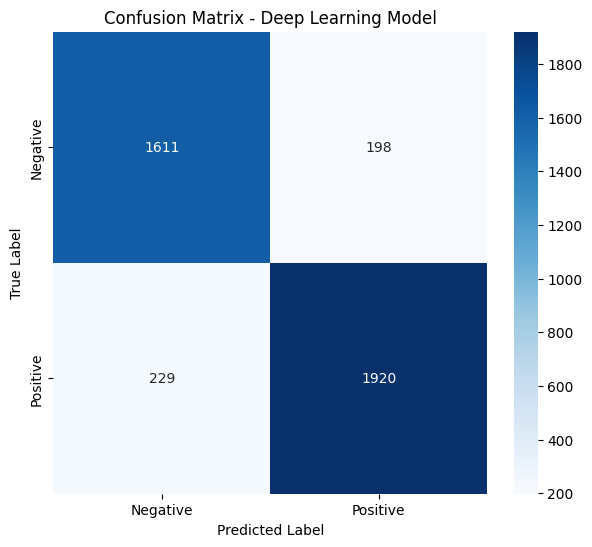

In [260]:
# Plot Confusion Matrix
cm_dl = confusion_matrix(y_test_dl, y_pred_dl)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Deep Learning Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



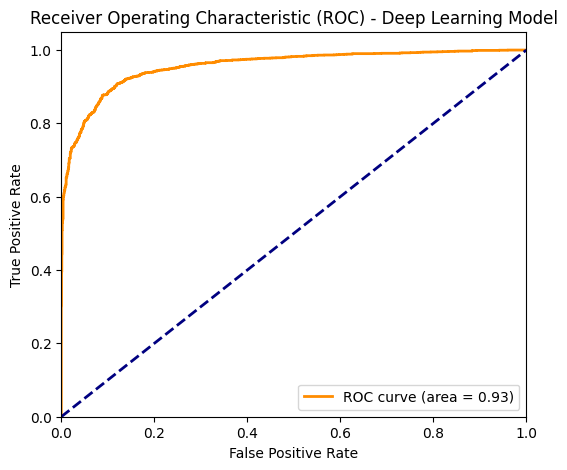

In [261]:
# Plot ROC Curve
fpr_dl, tpr_dl, _ = roc_curve(y_test_dl, y_pred_proba_dl)
plt.figure(figsize=(6, 5))
plt.plot(fpr_dl, tpr_dl, color='darkorange', lw=2, label=f'ROC curve (area = {auc_dl:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Deep Learning Model')
plt.legend(loc="lower right")
plt.show()

In [264]:
# --- Dynamically pull metrics for Tuned Logistic Regression ---
accuracy_lr_tuned = accuracy_score(y_test, y_pred_best)
roc_auc_lr_tuned = roc_auc_score(y_test, y_pred_proba_best)
class_report_lr_tuned = classification_report(y_test, y_pred_best, target_names=['negative', 'positive'], output_dict=True)
f1_neg_lr_tuned = class_report_lr_tuned['negative']['f1-score']
f1_pos_lr_tuned = class_report_lr_tuned['positive']['f1-score']
f1_weighted_lr_tuned = class_report_lr_tuned['weighted avg']['f1-score'] # ADDED
cm_lr_tuned = confusion_matrix(y_test, y_pred_best)
tn_lr_tuned, fp_lr_tuned, fn_lr_tuned, tp_lr_tuned = cm_lr_tuned.ravel()

# --- Dynamically pull metrics for Deep Learning Model ---
accuracy_dl_calculated = accuracy_score(y_test_dl, y_pred_dl)
roc_auc_dl_calculated = roc_auc_score(y_test_dl, y_pred_proba_dl)
class_report_dl_calculated = classification_report(y_test_dl, y_pred_dl, target_names=['negative', 'positive'], output_dict=True)
f1_neg_dl_calculated = class_report_dl_calculated['negative']['f1-score']
f1_pos_dl_calculated = class_report_dl_calculated['positive']['f1-score']
f1_weighted_dl_calculated = class_report_dl_calculated['weighted avg']['f1-score'] # ADDED
cm_dl_calculated = confusion_matrix(y_test_dl, y_pred_dl)
tn_dl_calculated, fp_dl_calculated, fn_dl_calculated, tp_dl_calculated = cm_dl_calculated.ravel()

# --- Create a dictionary to hold only the two models' results ---
comparison_data = {
    'Model': [
        'Tuned Logistic Regression',
        'Deep Learning Model'
    ],
    'Accuracy': [
        accuracy_lr_tuned,
        accuracy_dl_calculated
    ],
    'ROC-AUC': [
        roc_auc_lr_tuned,
        roc_auc_dl_calculated
    ],
    'Negative F1': [
        f1_neg_lr_tuned,
        f1_neg_dl_calculated
    ],
    'Positive F1': [
        f1_pos_lr_tuned,
        f1_pos_dl_calculated
    ],
    'Weighted F1': [ # ADDED THIS COLUMN
        f1_weighted_lr_tuned,
        f1_weighted_dl_calculated
    ],
    'True Negatives (TN)': [
        tn_lr_tuned,
        tn_dl_calculated
    ],
    'False Positives (FP)': [
        fp_lr_tuned,
        fp_dl_calculated
    ],
    'False Negatives (FN)': [
        fn_lr_tuned,
        fn_dl_calculated
    ],
    'True Positives (TP)': [
        tp_lr_tuned,
        tp_dl_calculated
    ]
}

# Create a DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Convert to HTML and print
html_output = comparison_df.to_html(index=False)
display(HTML(html_output))

Model,Accuracy,ROC-AUC,Negative F1,Positive F1,Weighted F1,True Negatives (TN),False Positives (FP),False Negatives (FN),True Positives (TP)
Tuned Logistic Regression,0.907024,0.969212,0.898230,0.914419,0.907020,1624,185,183,1966
Deep Learning Model,0.892117,0.955992,0.882982,0.899930,0.892184,1611,198,229,1920
